## Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
data_path = "forecasting_case_study.xlsx"
sales_data = pd.read_excel(data_path)
sales_data.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2017-02-05,27750,0.00,0,0,0,0.0,0,0,0,0
1,SKU1,2017-02-12,29023,0.00,1,0,1,0.0,0,1,0,0
2,SKU1,2017-02-19,45630,0.17,0,0,0,0.0,0,0,0,0
3,SKU1,2017-02-26,26789,0.00,1,0,1,0.0,0,0,0,0
4,SKU1,2017-03-05,41999,0.17,0,0,0,0.0,0,0,0,0


In [3]:
sales_data.shape

(1218, 12)

## Checking for Missing Values and Replicates

In [4]:
sales_data.isna().sum()

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

In [5]:
sales_data.duplicated().sum()

0

First we check wheter there is any replicate rows or any NA values in the dataframe, and the result shows that there is none.

In [7]:
print("Number of duplicate dates in original data:", sales_data['date'].duplicated().sum())


Number of duplicate dates in original data: 1014


In [8]:
sales_data_df= sales_data['date'].duplicated()
sales_data_df

0       False
1       False
2       False
3       False
4       False
        ...  
1213     True
1214     True
1215     True
1216     True
1217     True
Name: date, Length: 1218, dtype: bool

The date column has duplicated rows but those are basically repeated because of different product sold in the same days. So we will not change those duplicated rows, and we will analyze each product seperately for their sales.

We checking whether there are missing weeks in the data by checking the number of weeks between the beginning date with the end date.

In [51]:
weekly_data = pd.DataFrame(pd.date_range(start=sales_data['date'].min(),end=sales_data['date'].max(),freq='W'))
weekly_data.rename(columns={weekly_data.columns[0]: "Date"}, inplace = True)
weekly_data.describe()

,Date
count,204
mean,2019-01-16 12:00:00
min,2017-02-05 00:00:00
25%,2018-01-26 06:00:00
50%,2019-01-16 12:00:00
75%,2020-01-06 18:00:00
max,2020-12-27 00:00:00


Our data are recorded weekly, and we see that there are 204 weeks in total. For 6 products, we should have 204*6=1224 records, but we only have 1218. So we need to check how many records do we have for each product.

In [54]:
for i in range(1, 7):
    product = "SKU" + str(i)
    product_data = sales_data[sales_data["Product"] == product]
    print(product_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 0 to 203
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Product                     204 non-null    object        
 1   date                        204 non-null    datetime64[ns]
 2   Sales                       204 non-null    int64         
 3   Price Discount (%)          204 non-null    float64       
 4   In-Store Promo              204 non-null    int64         
 5   Catalogue Promo             204 non-null    int64         
 6   Store End Promo             204 non-null    int64         
 7   Google_Mobility             204 non-null    float64       
 8   Covid_Flag                  204 non-null    int64         
 9   V_DAY                       204 non-null    int64         
 10  EASTER                      204 non-null    int64         
 11  CHRISTMAS                   204 non-null    int64         
 12 

In [56]:
SKU6_data = sales_data[sales_data["Product"] == 'SKU6']
print(SKU6_data['date'].min(), SKU6_data['date'].max())

2017-02-05 00:00:00 2020-11-15 00:00:00


It turns out that we are only missing data from the product `SKU6`, and all the missing dates are towards the end. In other words, if we look at `SKU6` alone, it has no missing data, just an earlier end date. This means that we can analyze `SKU6` with the current data without having to worry about the missing data. Thus for this dataset, we do not need to deal with missing data.

## Check for Outliers

In [10]:
for col in sales_data.iloc[:, 4:]:
    print(col, ":", sales_data[col].unique())

In-Store Promo : [0 1]
Catalogue Promo : [0 1]
Store End Promo : [0 1]
Google_Mobility : [  0.     2.36   3.3    3.9    3.81   3.01   0.26 -15.7  -26.63 -28.49
 -27.3  -24.28 -22.58 -18.18 -15.91 -15.27 -13.24 -10.86 -10.13  -8.68
  -8.57  -7.5   -8.04  -9.36  -8.77  -9.93 -11.65 -13.23 -20.35 -19.41
 -18.83 -16.44  -7.28  -9.87  -7.79  -9.73  -7.39  -7.56  -8.39  -7.43
  -5.95  -7.2   -5.96  -5.3   -4.38  -4.74 -10.27  -6.95]
Covid_Flag : [0 1]
V_DAY : [0 1]
EASTER : [0 1]
CHRISTMAS : [0 1]


Then we check the values for the non-obvious columns to see whether they are categorical variables or numerical variable. For numerical variables, we can look for outliers and skewness. From above unique values in each row, we can see that only `Google_Mobility` (together with `Sales` and `Price Discount` which are ovbiously numerical) is numerical, and all other variables are categorical.

### General Overlook for All Numerical Variables

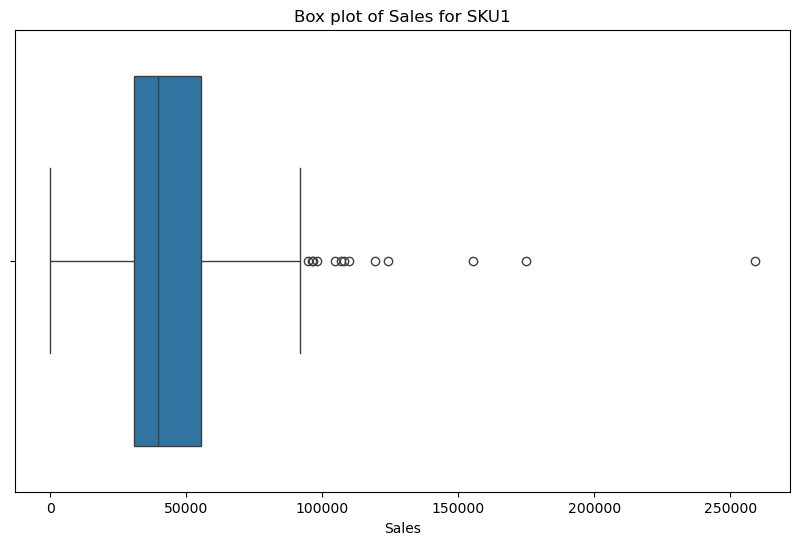

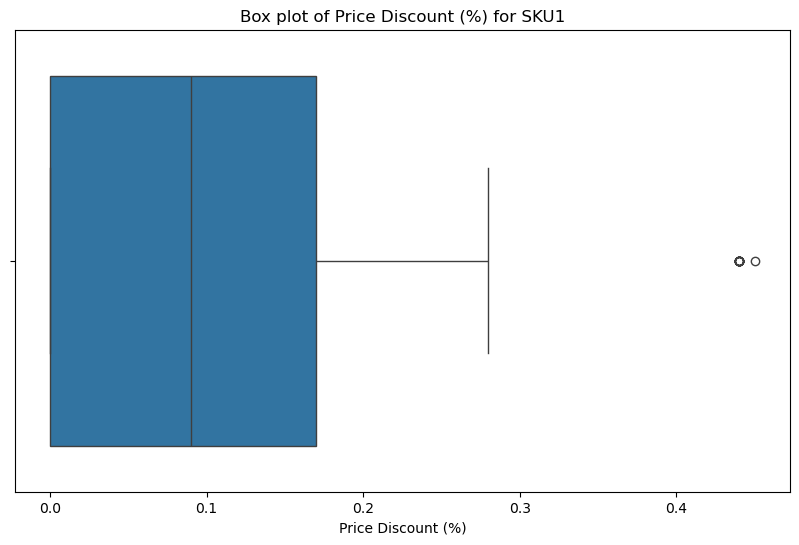

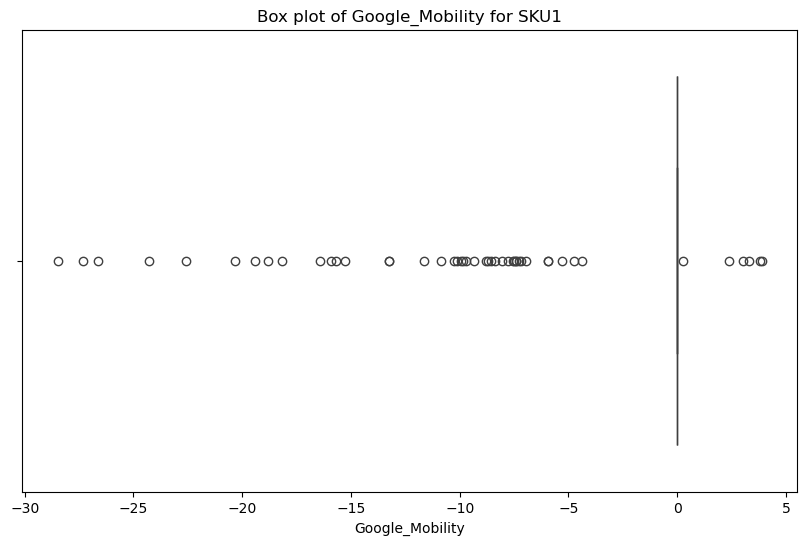

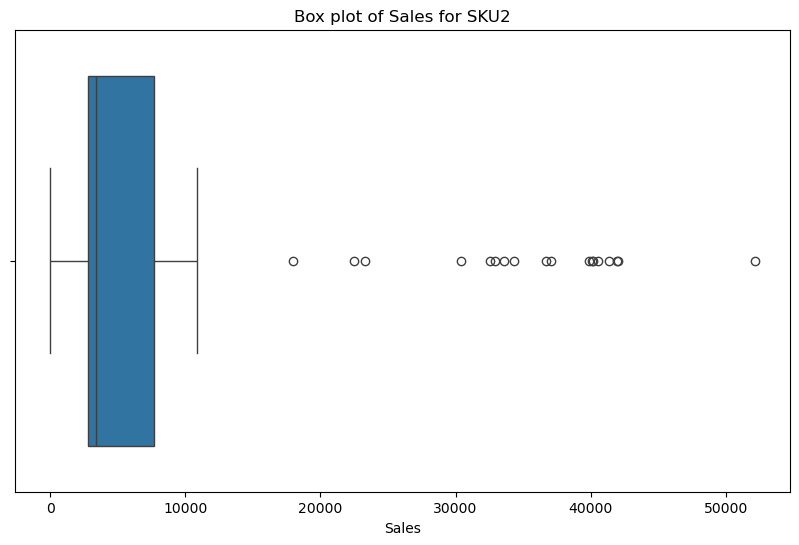

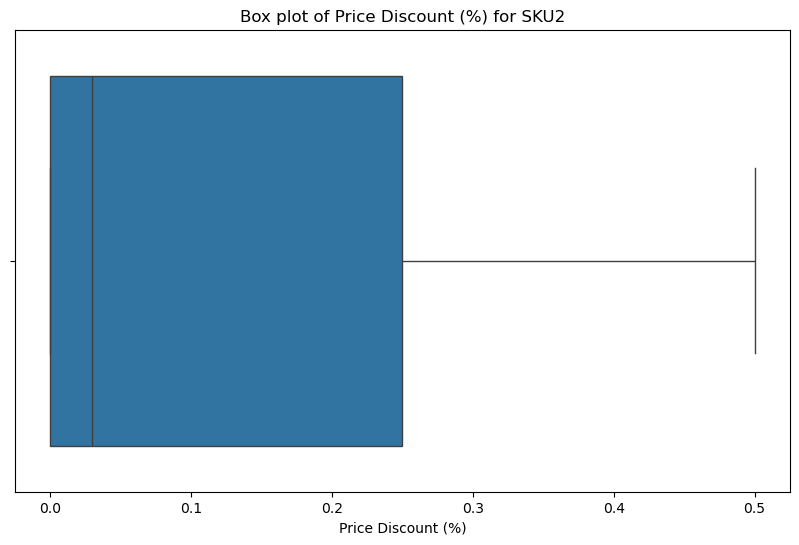

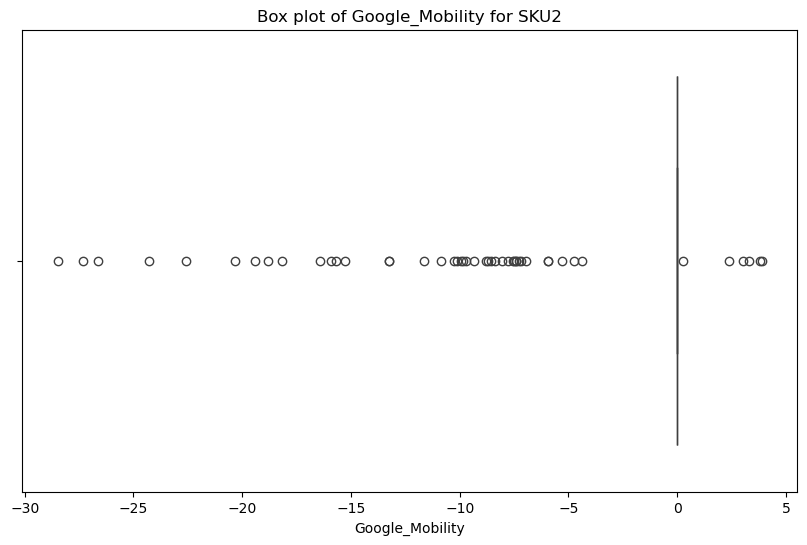

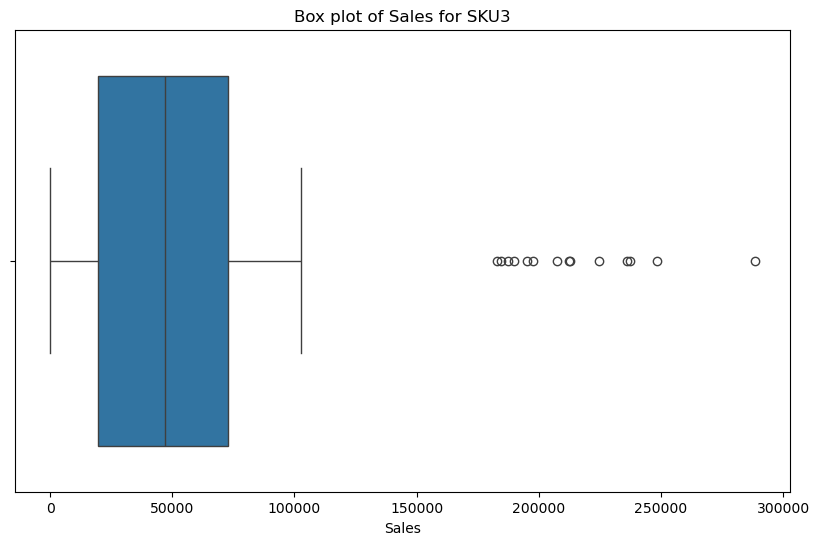

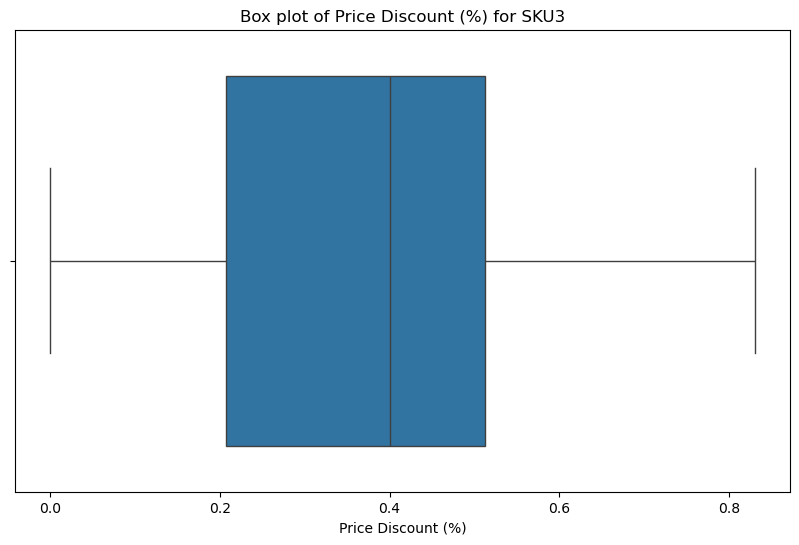

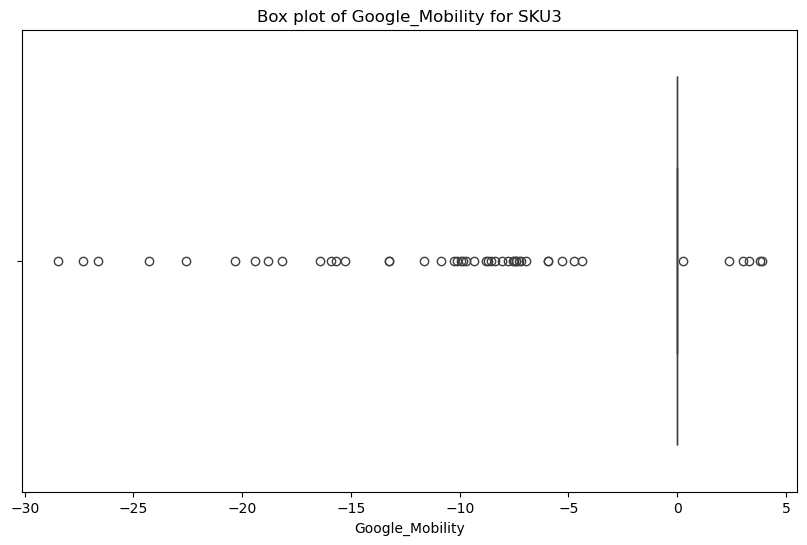

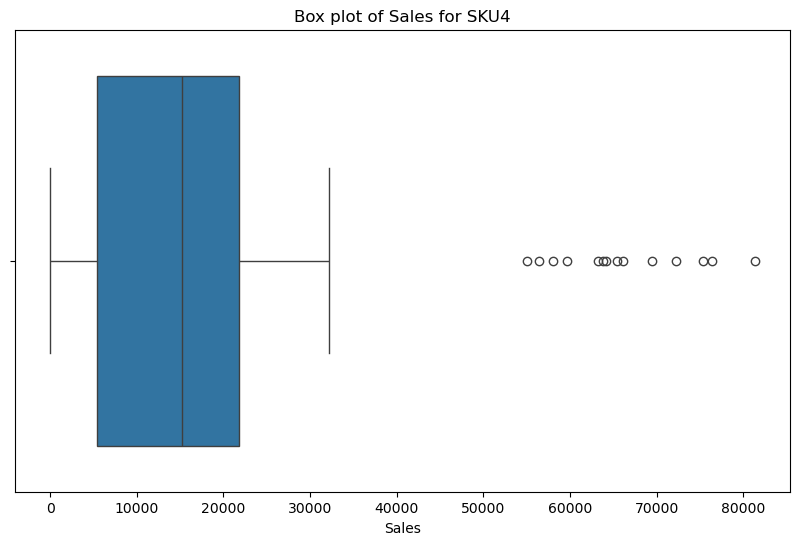

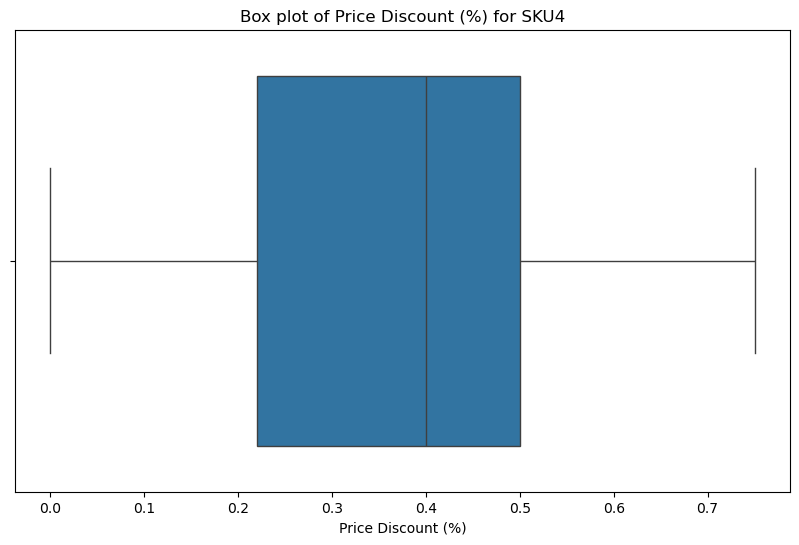

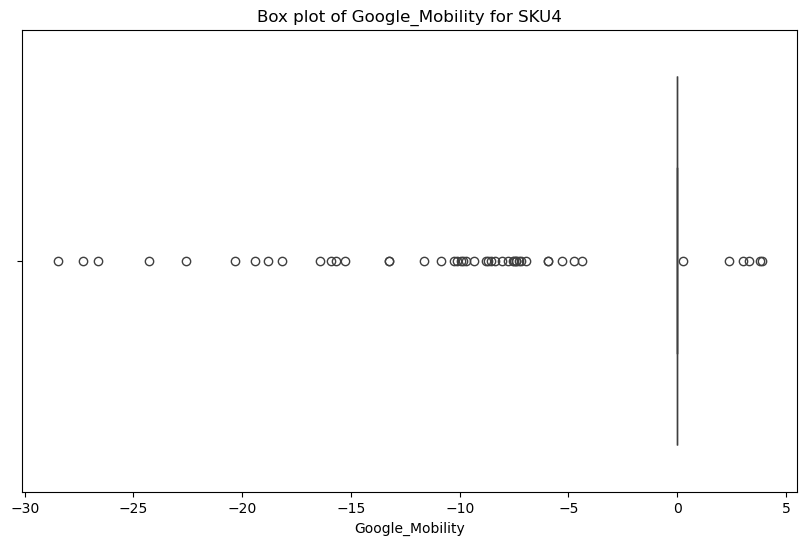

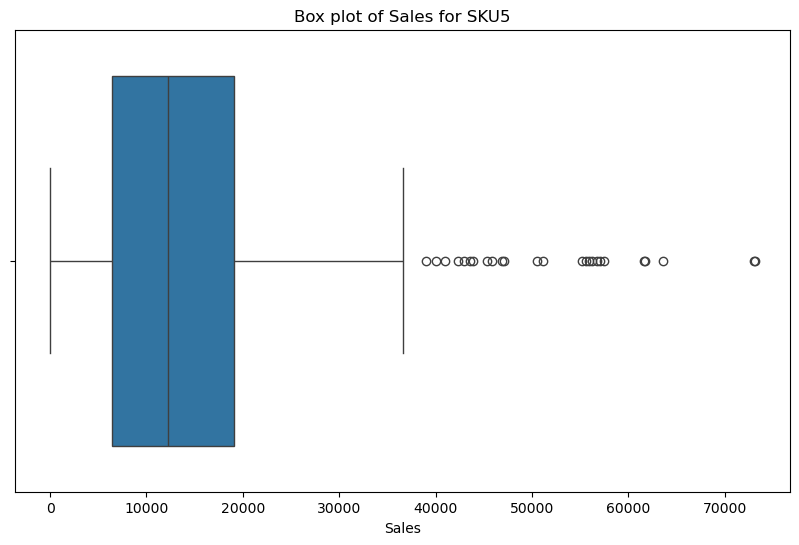

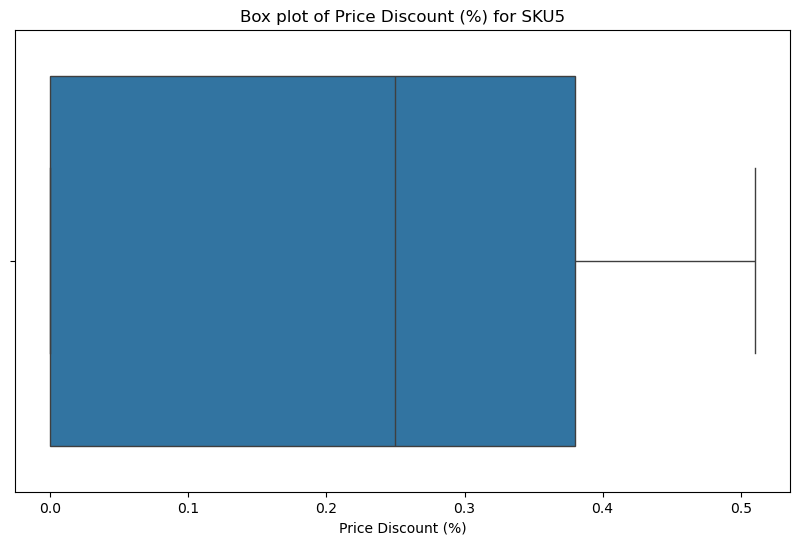

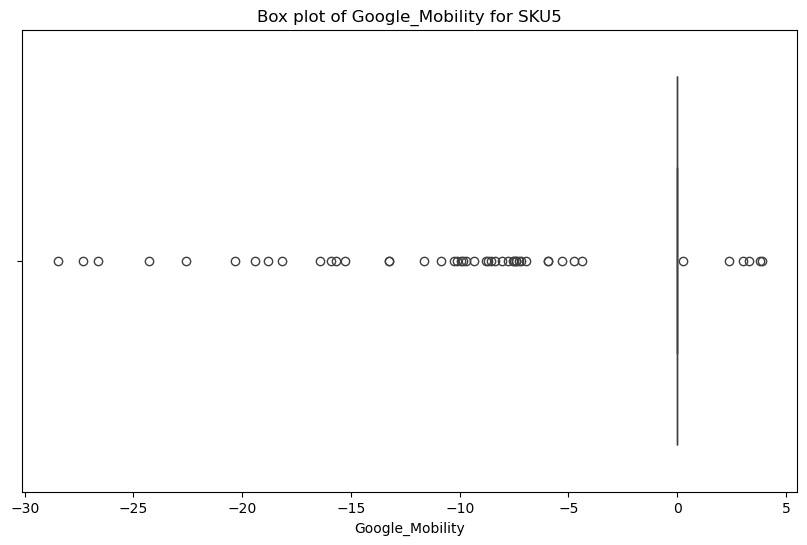

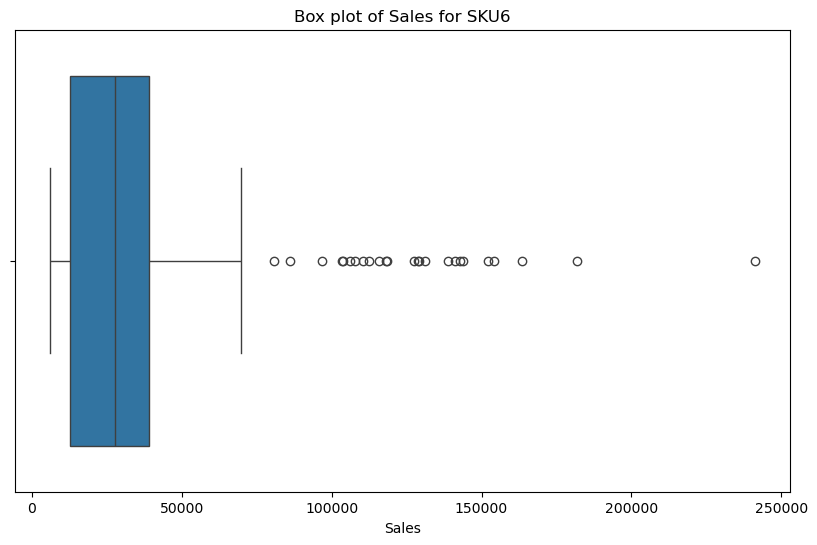

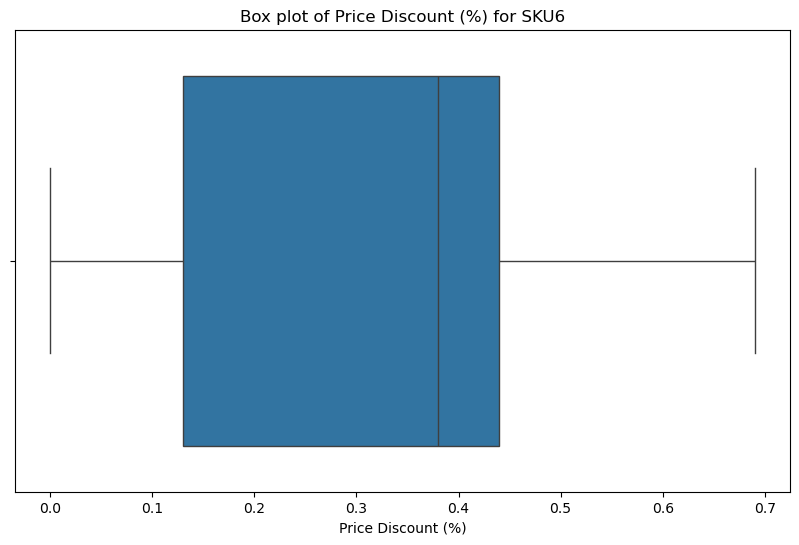

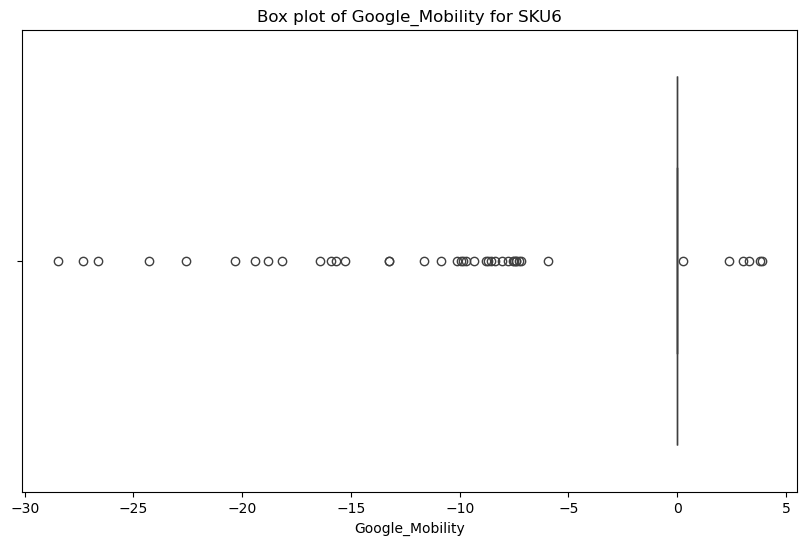

In [12]:
import seaborn as sns

for i in range(1, 7):
    product = "SKU" + str(i)
    product_data = sales_data[sales_data["Product"] == product]
    
    # Plot distributions for numeric columns to visualize outliers
    numeric_columns = ['Sales', 'Price Discount (%)', 'Google_Mobility']
    
    for col in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=product_data[col])
        plt.title(f'Box plot of {col} for {product}')
        plt.show()

We can see that for all products, `Sales` is right skewed and `Google_Mobility` is left skewed, while `Price Discount (%)` is more randomly scattered. There are some outliers in each category. We believe that since discount is scattered everwhere, and a lot of the outliers are actually the same value, so they are not truely outliers, but just the nature of the data. Therefore, we will not remove those. While for the other two columns, I believe we need to farther investigate into the patterns of the data before deciding whether they are turely outliers. If there are true outliers, we would want to replace with mean of the column. This is because each data point is important in analyzing the trends and we cannot simply remove rows with outliers.

### Sales

Analysis of SKU1
Outliers using Z-Score method:
           date   Sales
46  2017-12-24  155253
98  2018-12-23  174994
150 2019-12-22  258874
Outliers using IQR method:
           date   Sales
10  2017-04-16  108159
34  2017-10-01   96610
39  2017-11-05  104775
45  2017-12-17   94633
46  2017-12-24  155253
91  2018-11-04   97972
96  2018-12-09  109917
98  2018-12-23  174994
99  2018-12-30   96211
115 2019-04-21  119393
139 2019-10-06  106885
150 2019-12-22  258874
151 2019-12-29  124261


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3759945518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()


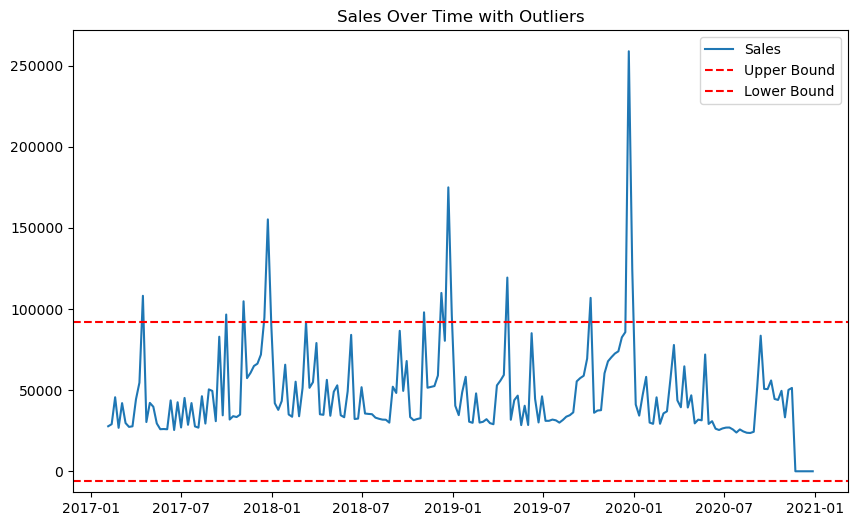

Analysis of SKU2
Outliers using Z-Score method:
           date  Sales
210 2017-03-19  41915
219 2017-05-21  52122
242 2017-10-29  40527
270 2018-05-13  41316
276 2018-06-24  42002
322 2019-05-12  36674
328 2019-06-23  37065
344 2019-10-13  40111
350 2019-11-24  39870
396 2020-10-11  40169
Outliers using IQR method:
           date  Sales
210 2017-03-19  41915
219 2017-05-21  52122
224 2017-06-25  33566
242 2017-10-29  40527
257 2018-02-11  32549
265 2018-04-08  17970
270 2018-05-13  41316
276 2018-06-24  42002
291 2018-10-07  32900
311 2019-02-24  23327
322 2019-05-12  36674
328 2019-06-23  37065
344 2019-10-13  40111
350 2019-11-24  39870
359 2020-01-26  30409
388 2020-08-16  34327
396 2020-10-11  40169
400 2020-11-08  22460


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3759945518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()


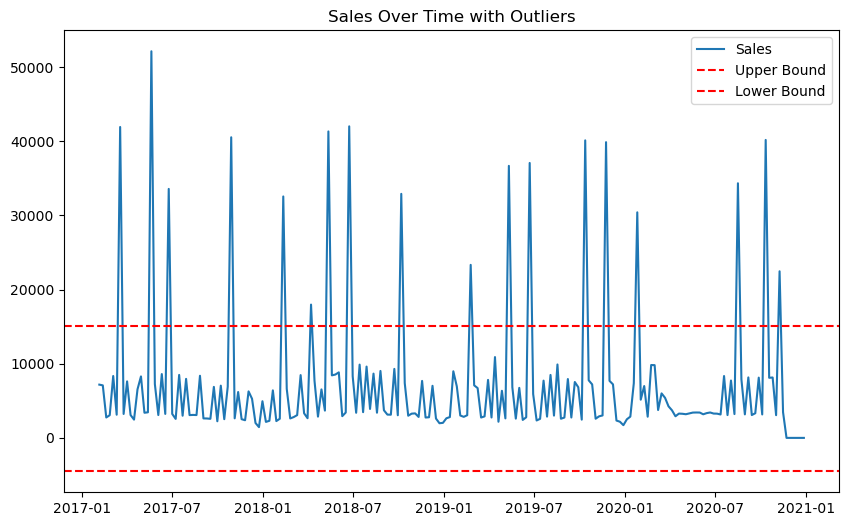

Analysis of SKU3
Outliers using Z-Score method:
           date   Sales
421 2017-05-07  212245
426 2017-06-11  248373
437 2017-08-27  236242
447 2017-11-05  212947
478 2018-06-10  288322
494 2018-09-30  237462
540 2019-08-18  224723
Outliers using IQR method:
           date   Sales
421 2017-05-07  212245
426 2017-06-11  248373
437 2017-08-27  236242
447 2017-11-05  212947
478 2018-06-10  288322
494 2018-09-30  237462
514 2019-02-17  195088
530 2019-06-09  197503
540 2019-08-18  224723
546 2019-09-29  207356
552 2019-11-10  182891
566 2020-02-16  187548
588 2020-07-19  184365
592 2020-08-16  189965


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3759945518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()


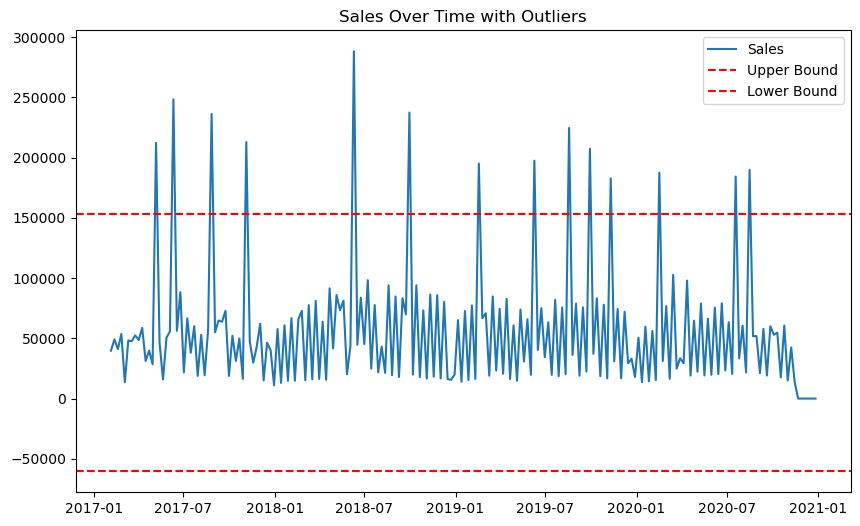

Analysis of SKU4
Outliers using Z-Score method:
           date  Sales
625 2017-05-07  65464
641 2017-08-27  75377
651 2017-11-05  69467
682 2018-06-10  72261
698 2018-09-30  66114
744 2019-08-18  64115
792 2020-07-19  76346
796 2020-08-16  81301
Outliers using IQR method:
           date  Sales
625 2017-05-07  65464
630 2017-06-11  63256
641 2017-08-27  75377
651 2017-11-05  69467
682 2018-06-10  72261
698 2018-09-30  66114
718 2019-02-17  63842
734 2019-06-09  59637
744 2019-08-18  64115
750 2019-09-29  56430
756 2019-11-10  54996
770 2020-02-16  58091
792 2020-07-19  76346
796 2020-08-16  81301


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3759945518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()


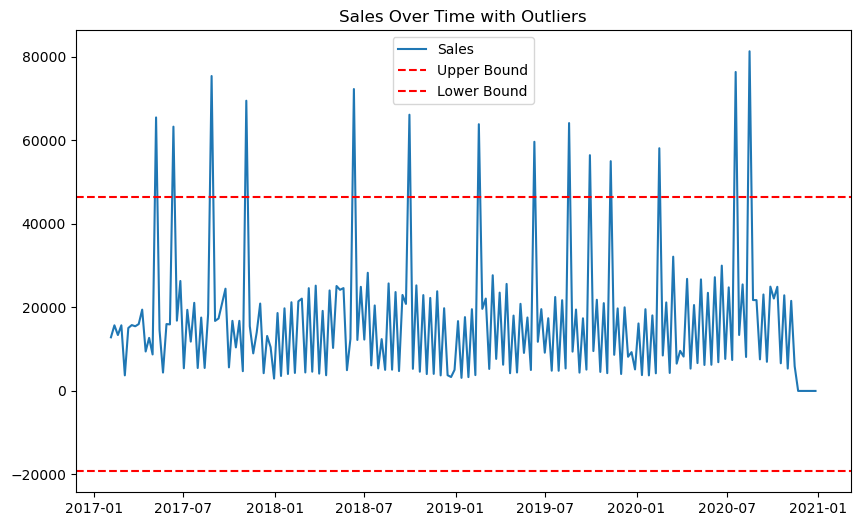

Analysis of SKU5
Outliers using Z-Score method:
           date  Sales
844 2017-08-20  73114
947 2019-08-11  63644
996 2020-07-19  73058
Outliers using IQR method:
            date  Sales
827  2017-04-23  42344
830  2017-05-14  45348
838  2017-07-09  55905
844  2017-08-20  73114
849  2017-09-24  55567
856  2017-11-12  50485
866  2018-01-21  51114
880  2018-04-29  42963
885  2018-06-03  55160
889  2018-07-01  56275
890  2018-07-08  43611
897  2018-08-26  46909
899  2018-09-09  45838
903  2018-10-07  40051
934  2019-05-12  47061
938  2019-06-09  57064
941  2019-06-30  61658
942  2019-07-07  39035
947  2019-08-11  63644
952  2019-09-15  56807
956  2019-10-13  57496
987  2020-05-17  61753
996  2020-07-19  73058
999  2020-08-09  43900
1001 2020-08-23  40956


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3759945518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()


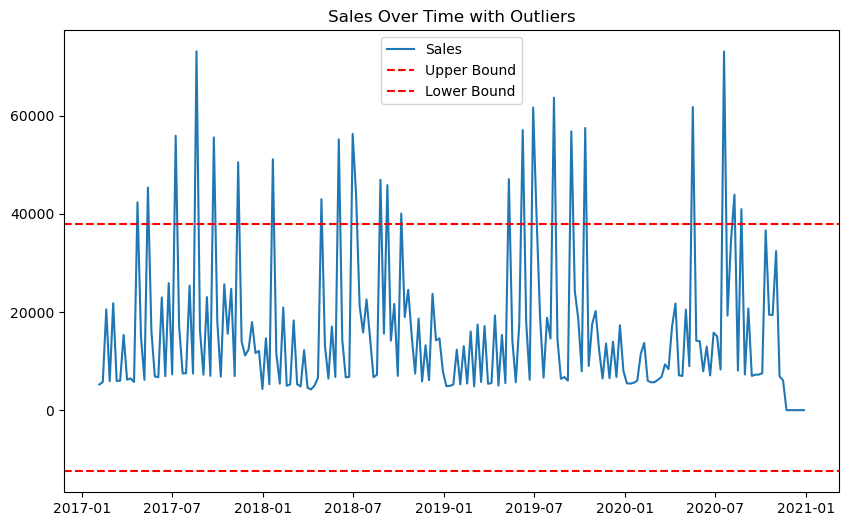

Analysis of SKU6
Outliers using Z-Score method:
            date   Sales
1058 2017-10-29  241114
1110 2018-10-28  181833
1163 2019-11-03  163536
Outliers using IQR method:
            date   Sales
1025 2017-03-12  118504
1037 2017-06-04  142953
1041 2017-07-02  131072
1046 2017-08-06  118276
1053 2017-09-24  129254
1057 2017-10-22  154098
1058 2017-10-29  241114
1077 2018-03-11  110490
1089 2018-06-03  128647
1095 2018-07-15  107913
1105 2018-09-23  127468
1109 2018-10-21  140995
1110 2018-10-28  181833
1111 2018-11-04  105995
1131 2019-03-24  112451
1139 2019-05-19   86119
1147 2019-07-14  103831
1157 2019-09-22  103617
1161 2019-10-20  138789
1162 2019-10-27  143887
1163 2019-11-03  163536
1209 2020-09-20   80769
1213 2020-10-18   96619
1214 2020-10-25  115798
1215 2020-11-01  152186


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3759945518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()


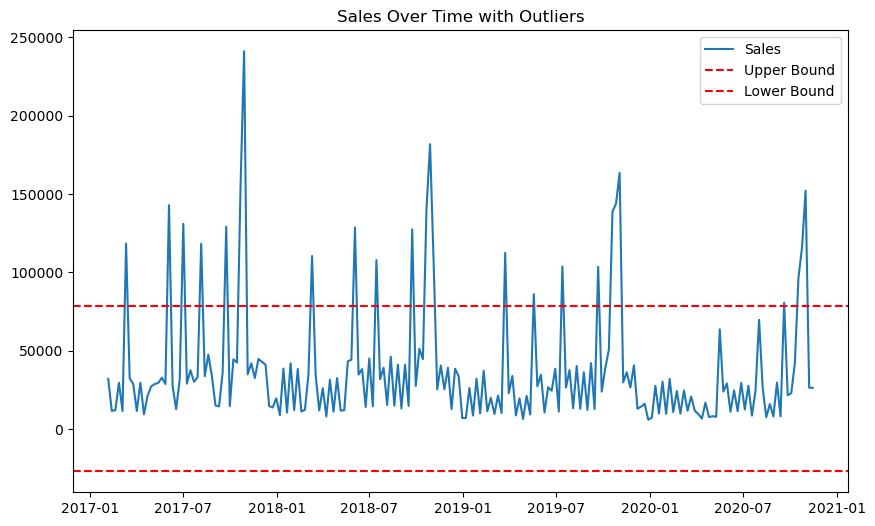

In [14]:
for i in range(1, 7):
    product = "SKU" + str(i)
    product_data = sales_data[sales_data["Product"] == product]
    print('Analysis of ' + product)
    # Z-Score Method to detect outliers in Sales
    product_data['Sales_Zscore'] = (product_data['Sales'] - product_data['Sales'].mean()) / product_data['Sales'].std()
    outliers = product_data[abs(product_data['Sales_Zscore']) > 3][['date', 'Sales']]
    print("Outliers using Z-Score method:\n", outliers)
    
    # IQR Method to detect outliers in Sales
    Q1 = product_data['Sales'].quantile(0.25)
    Q3 = product_data['Sales'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = product_data[(product_data['Sales'] < lower_bound) | (product_data['Sales'] > upper_bound)][['date', 'Sales']]
    print("Outliers using IQR method:\n", outliers_iqr)
    
    # Visualize Sales to identify outliers
    plt.figure(figsize=(10, 6))
    plt.plot(product_data['date'], product_data['Sales'], label='Sales')
    plt.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound')
    plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.title('Sales Over Time with Outliers')
    plt.legend()
    plt.show()

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
product_series = product_data.set_index('date').asfreq('W')

Trend for SKU1


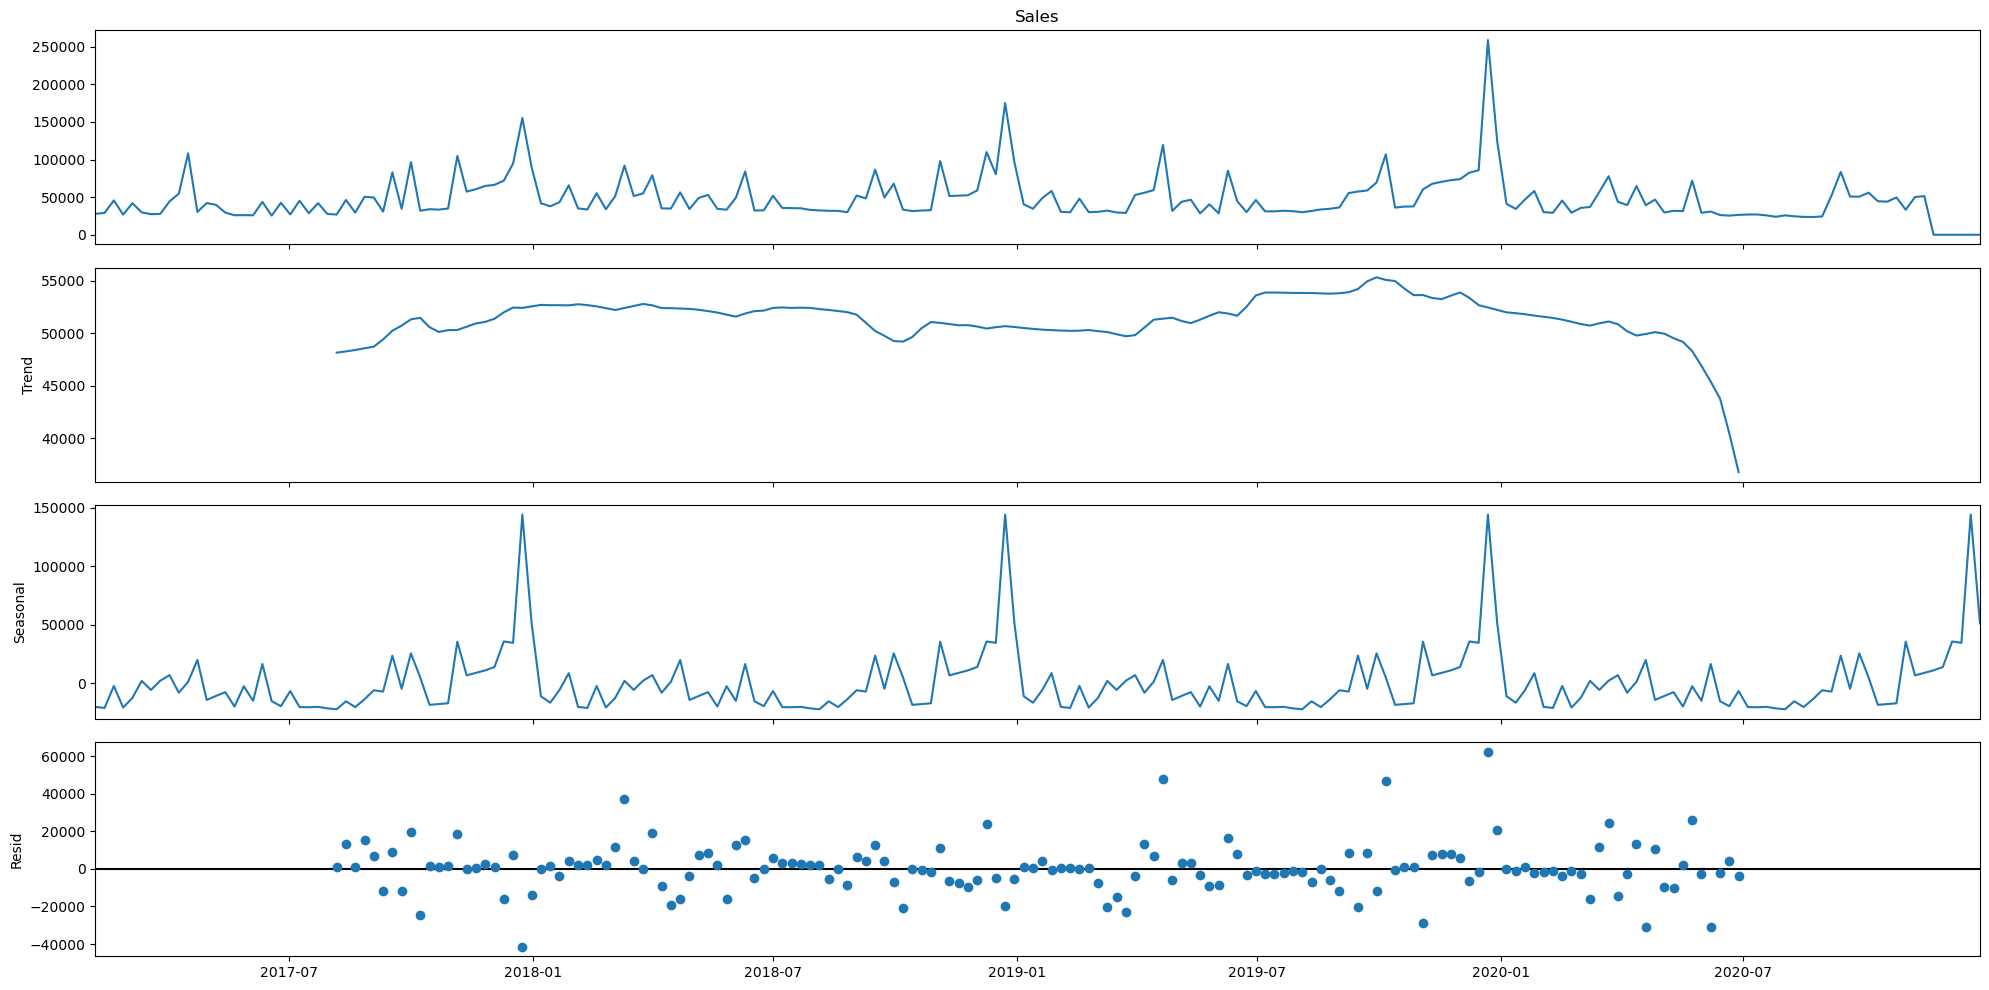

Trend for SKU2


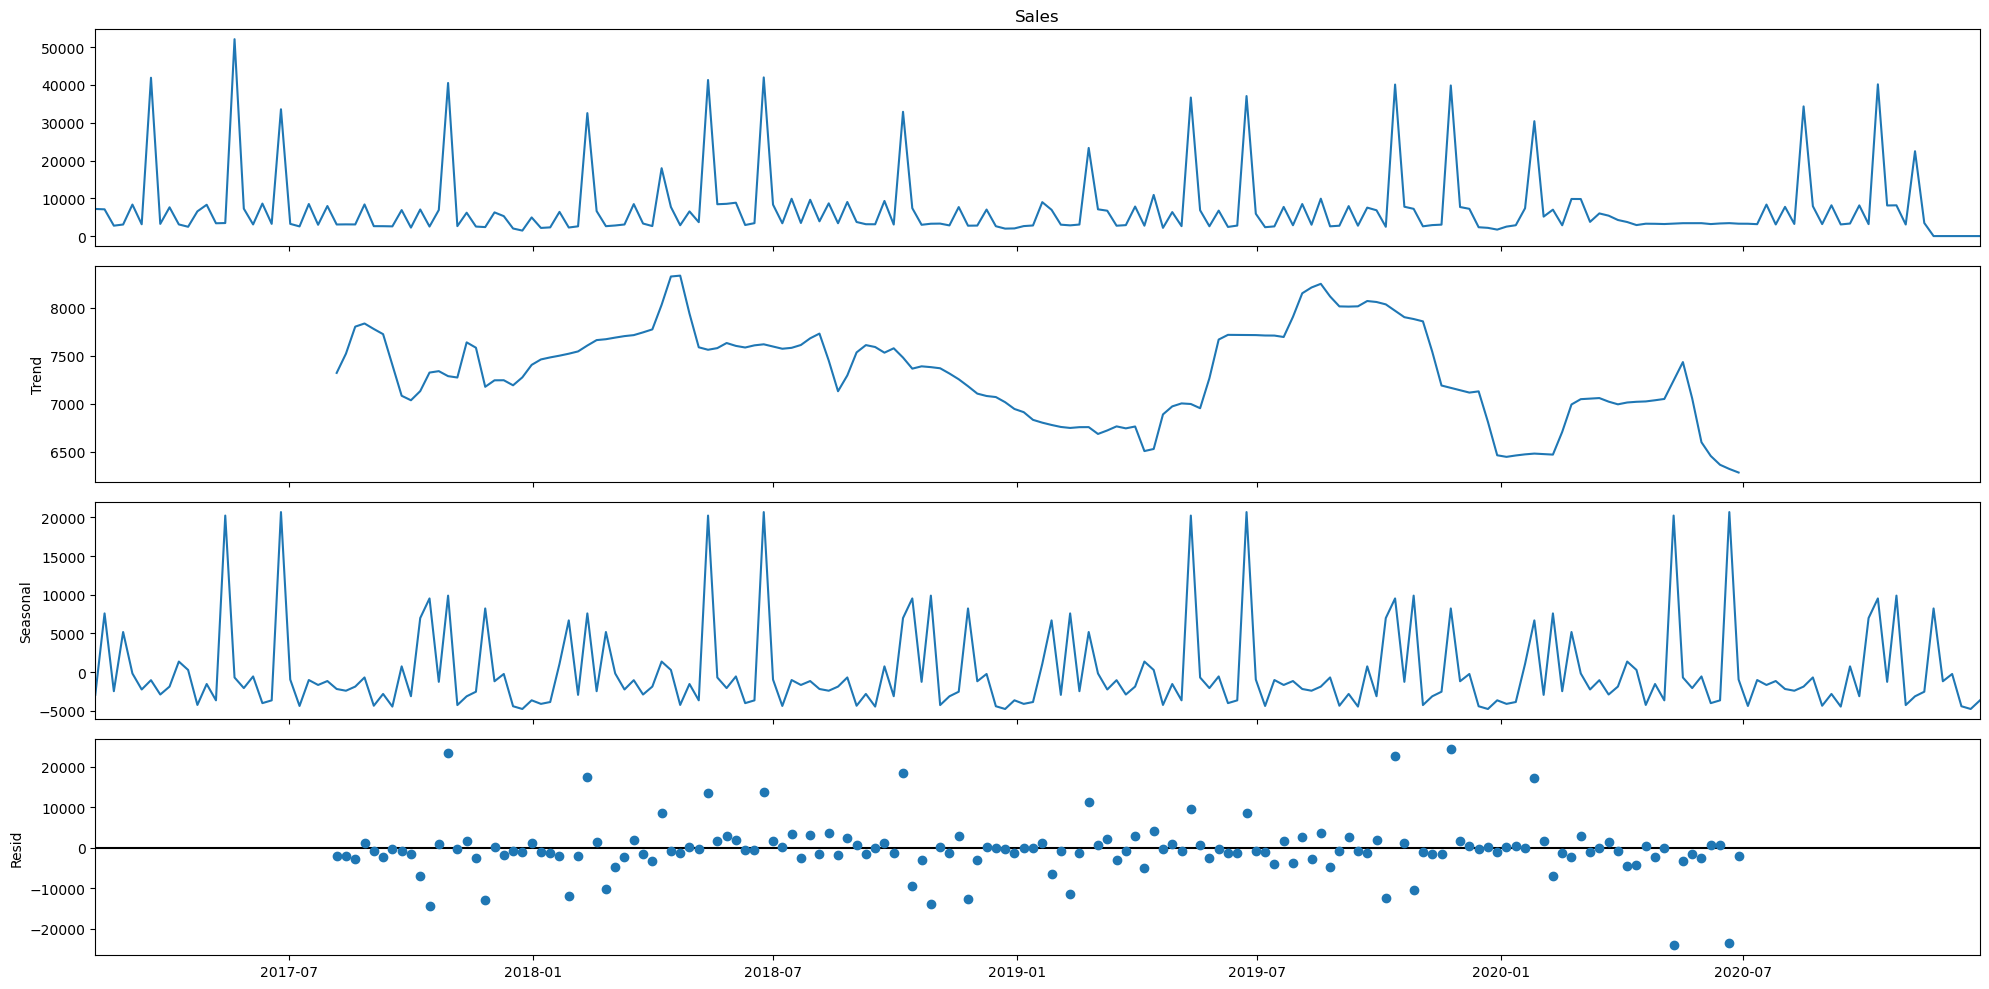

Trend for SKU3


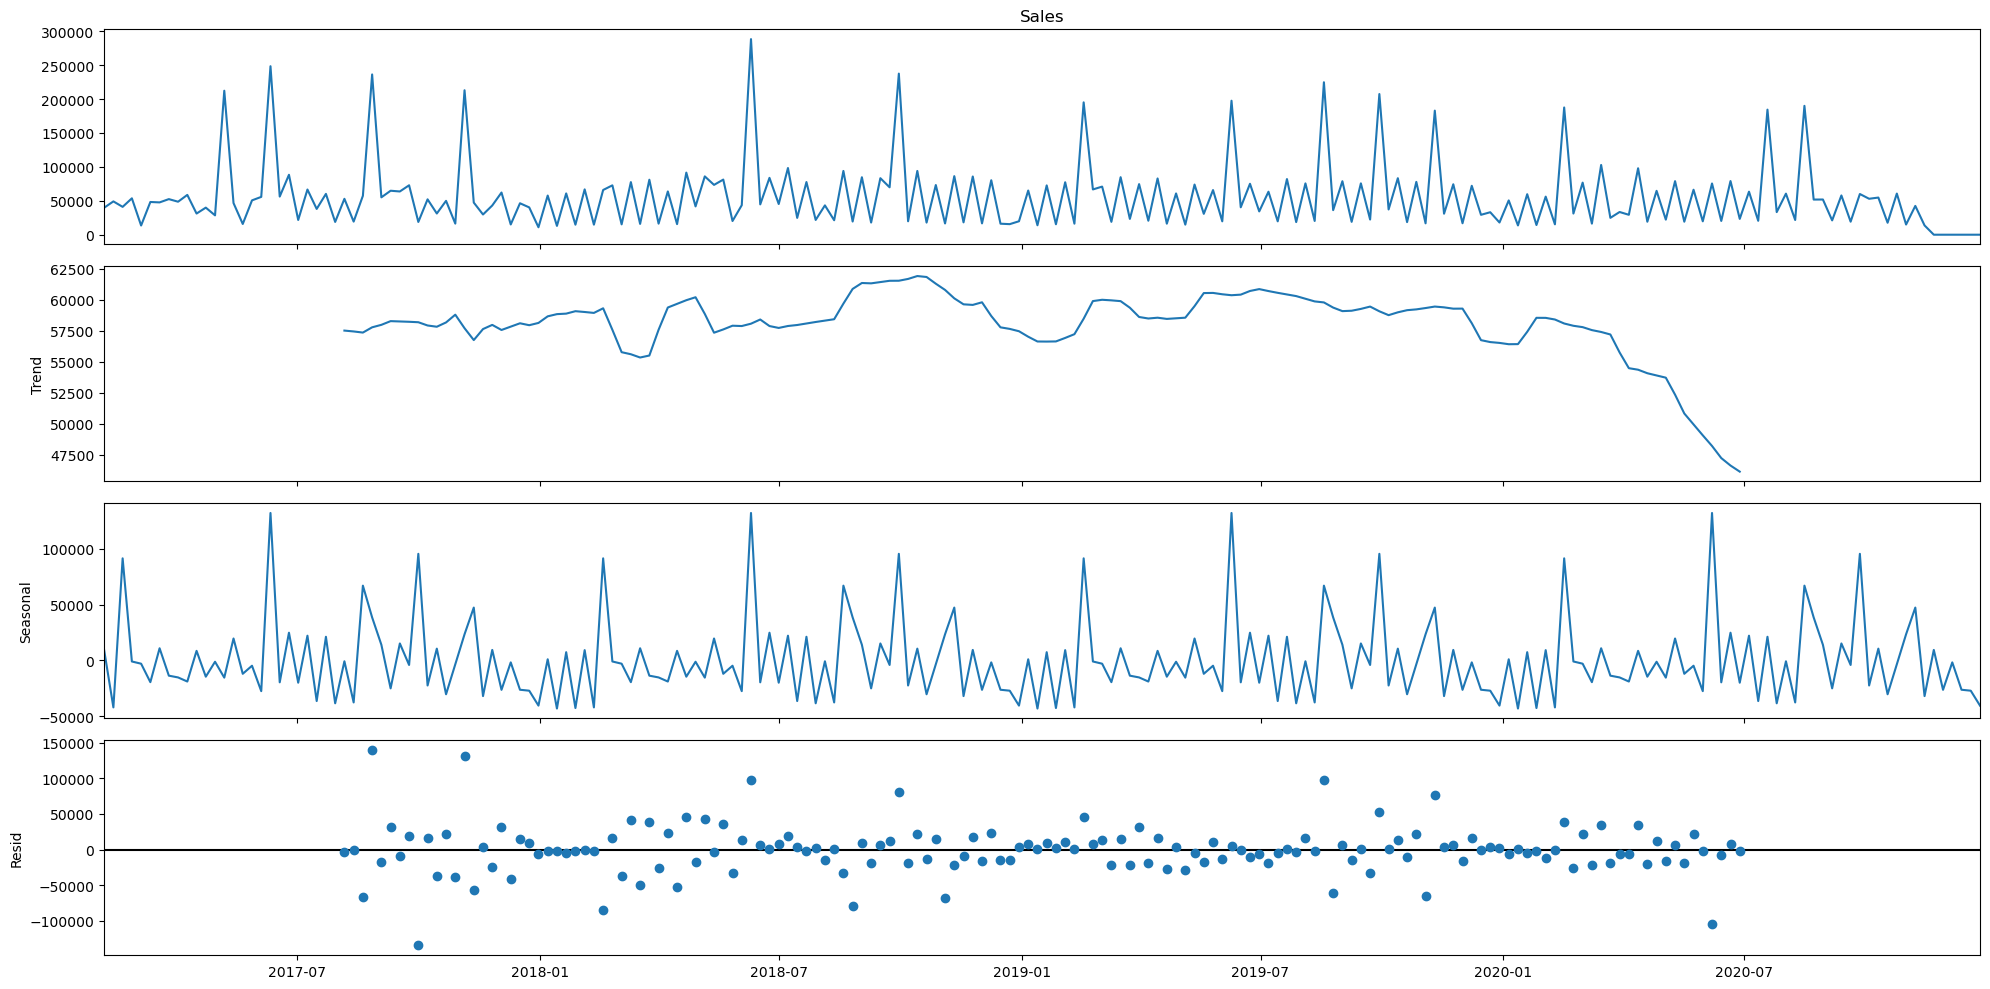

Trend for SKU4


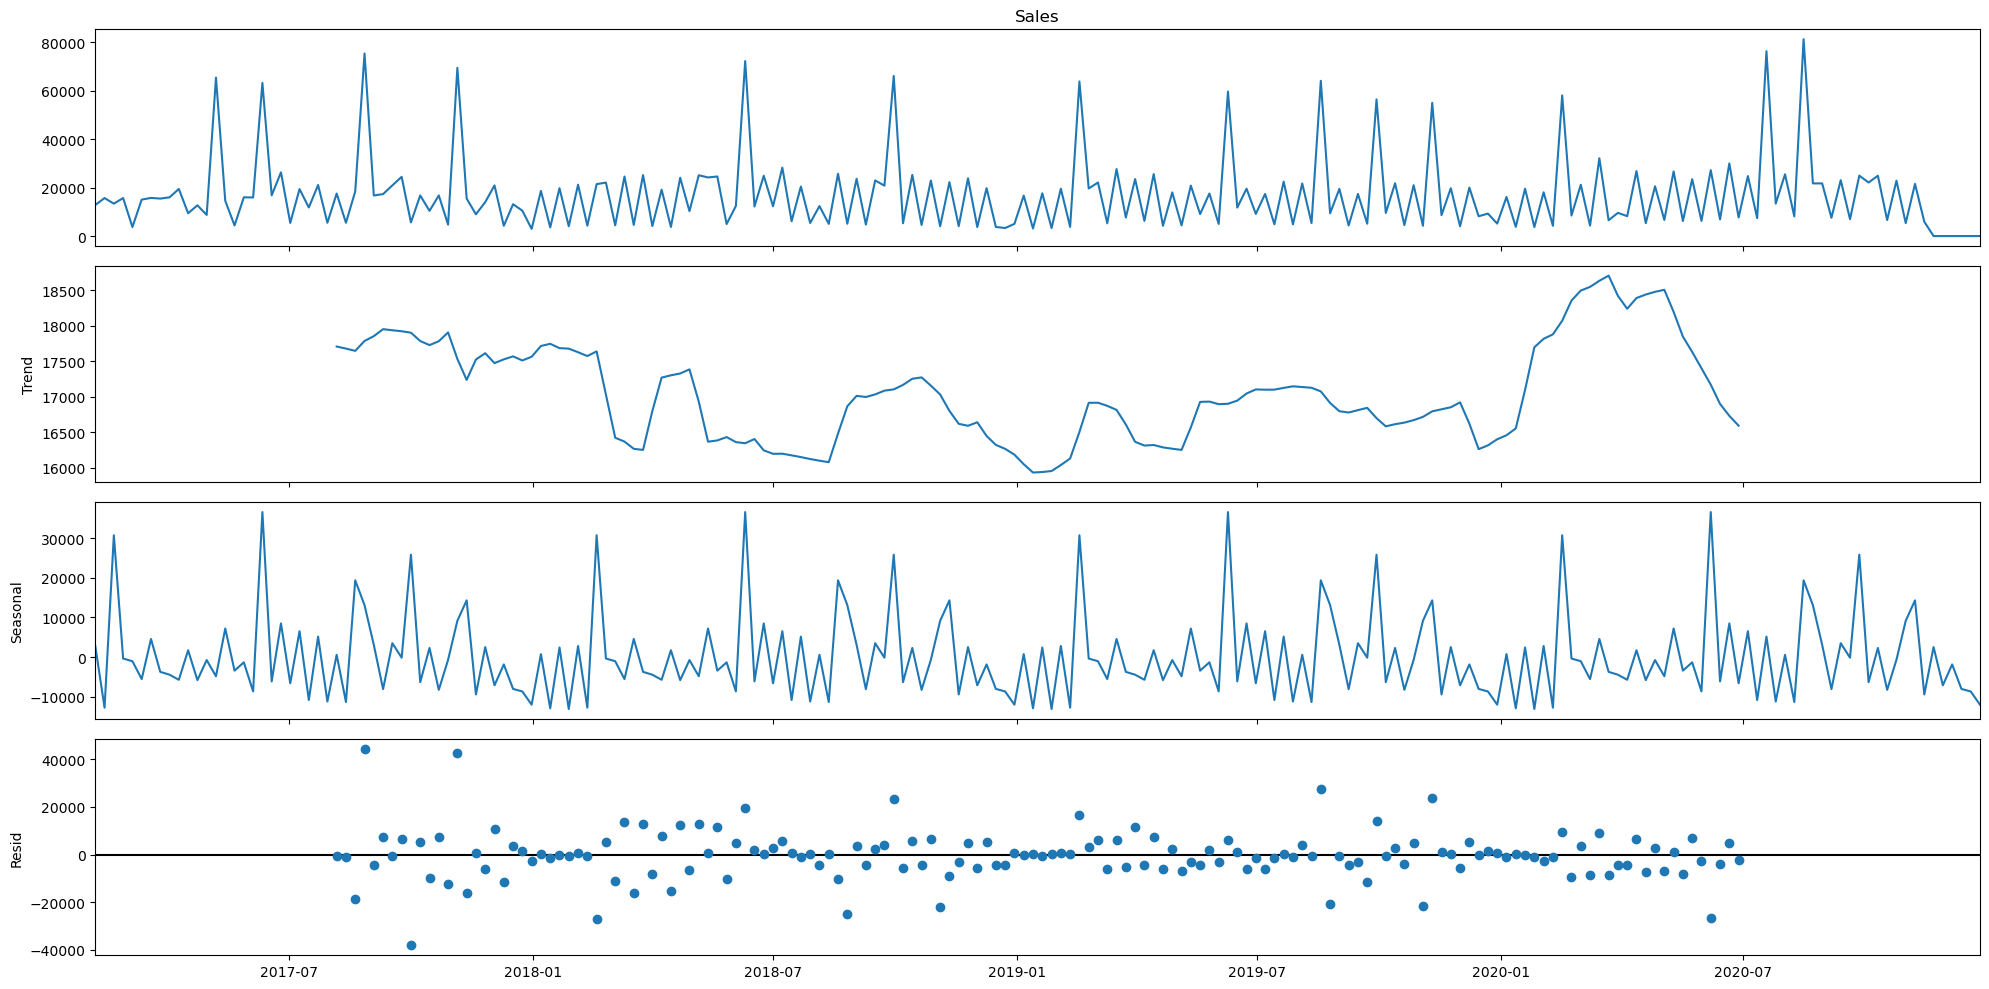

Trend for SKU5


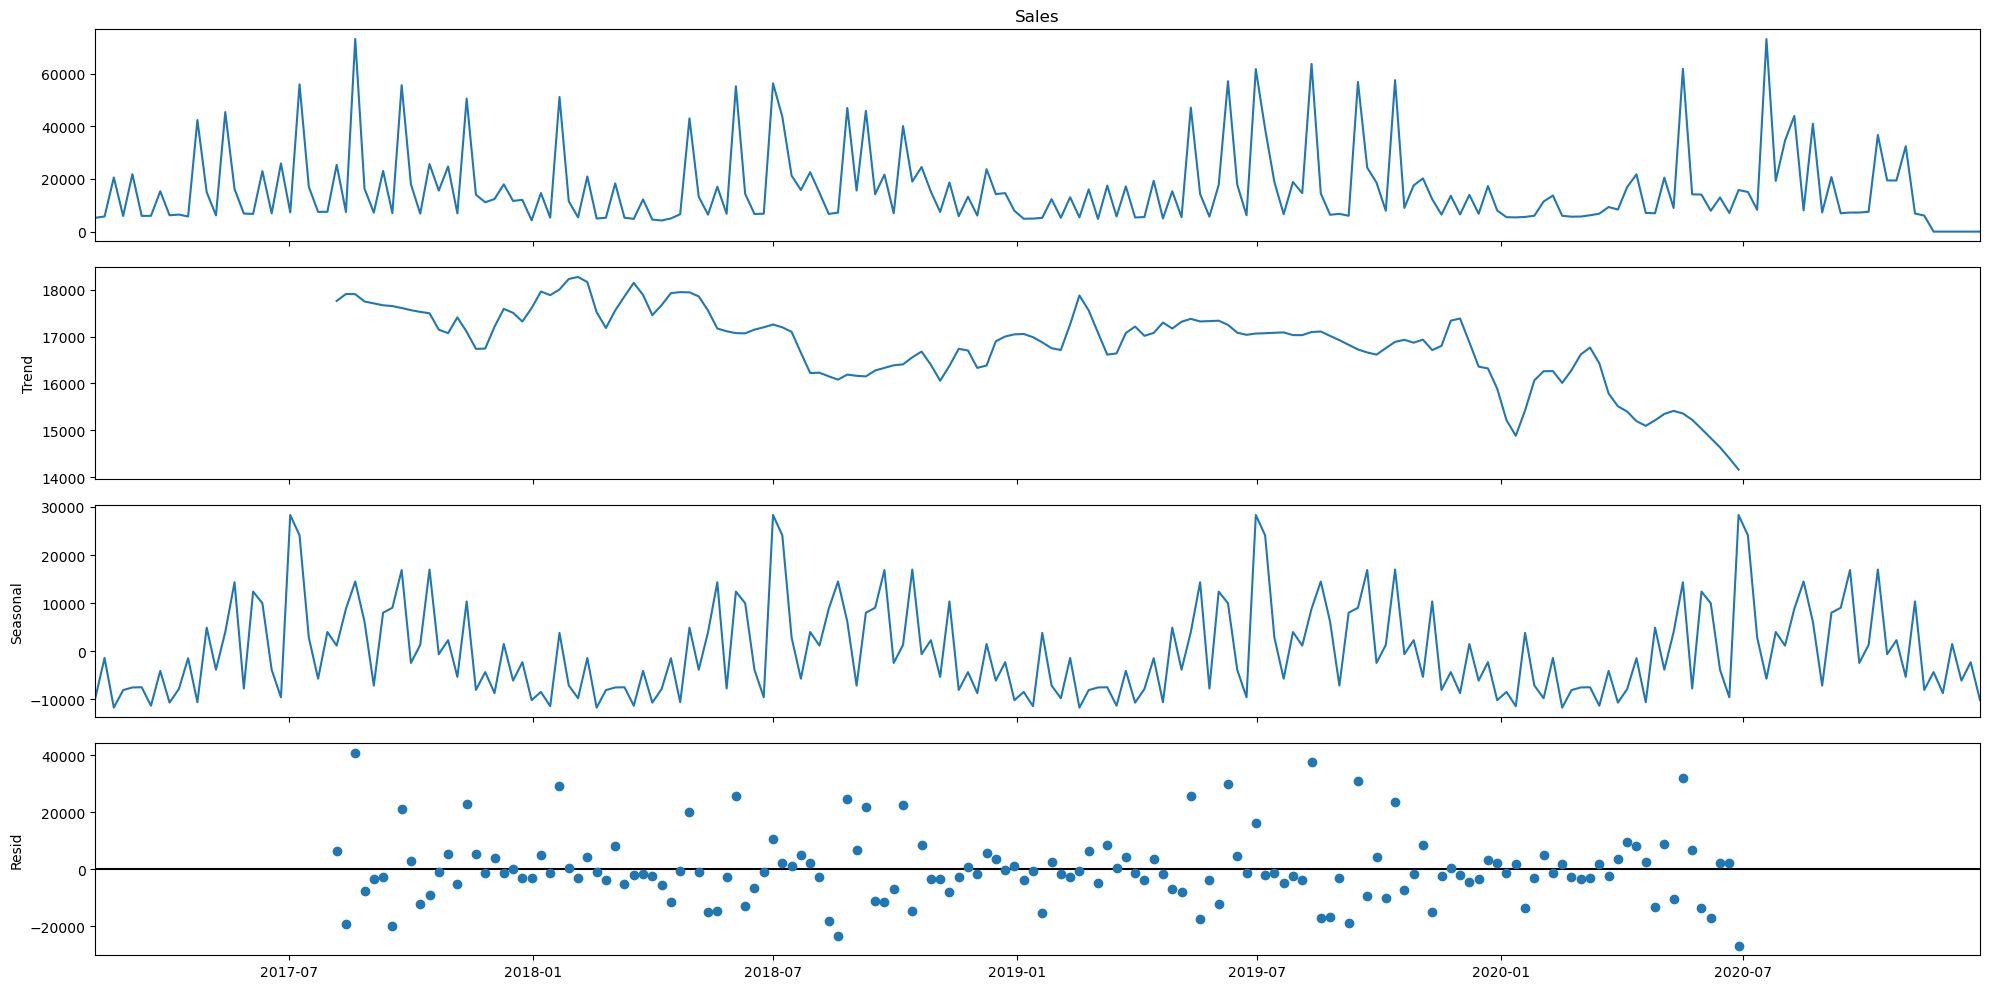

Trend for SKU6


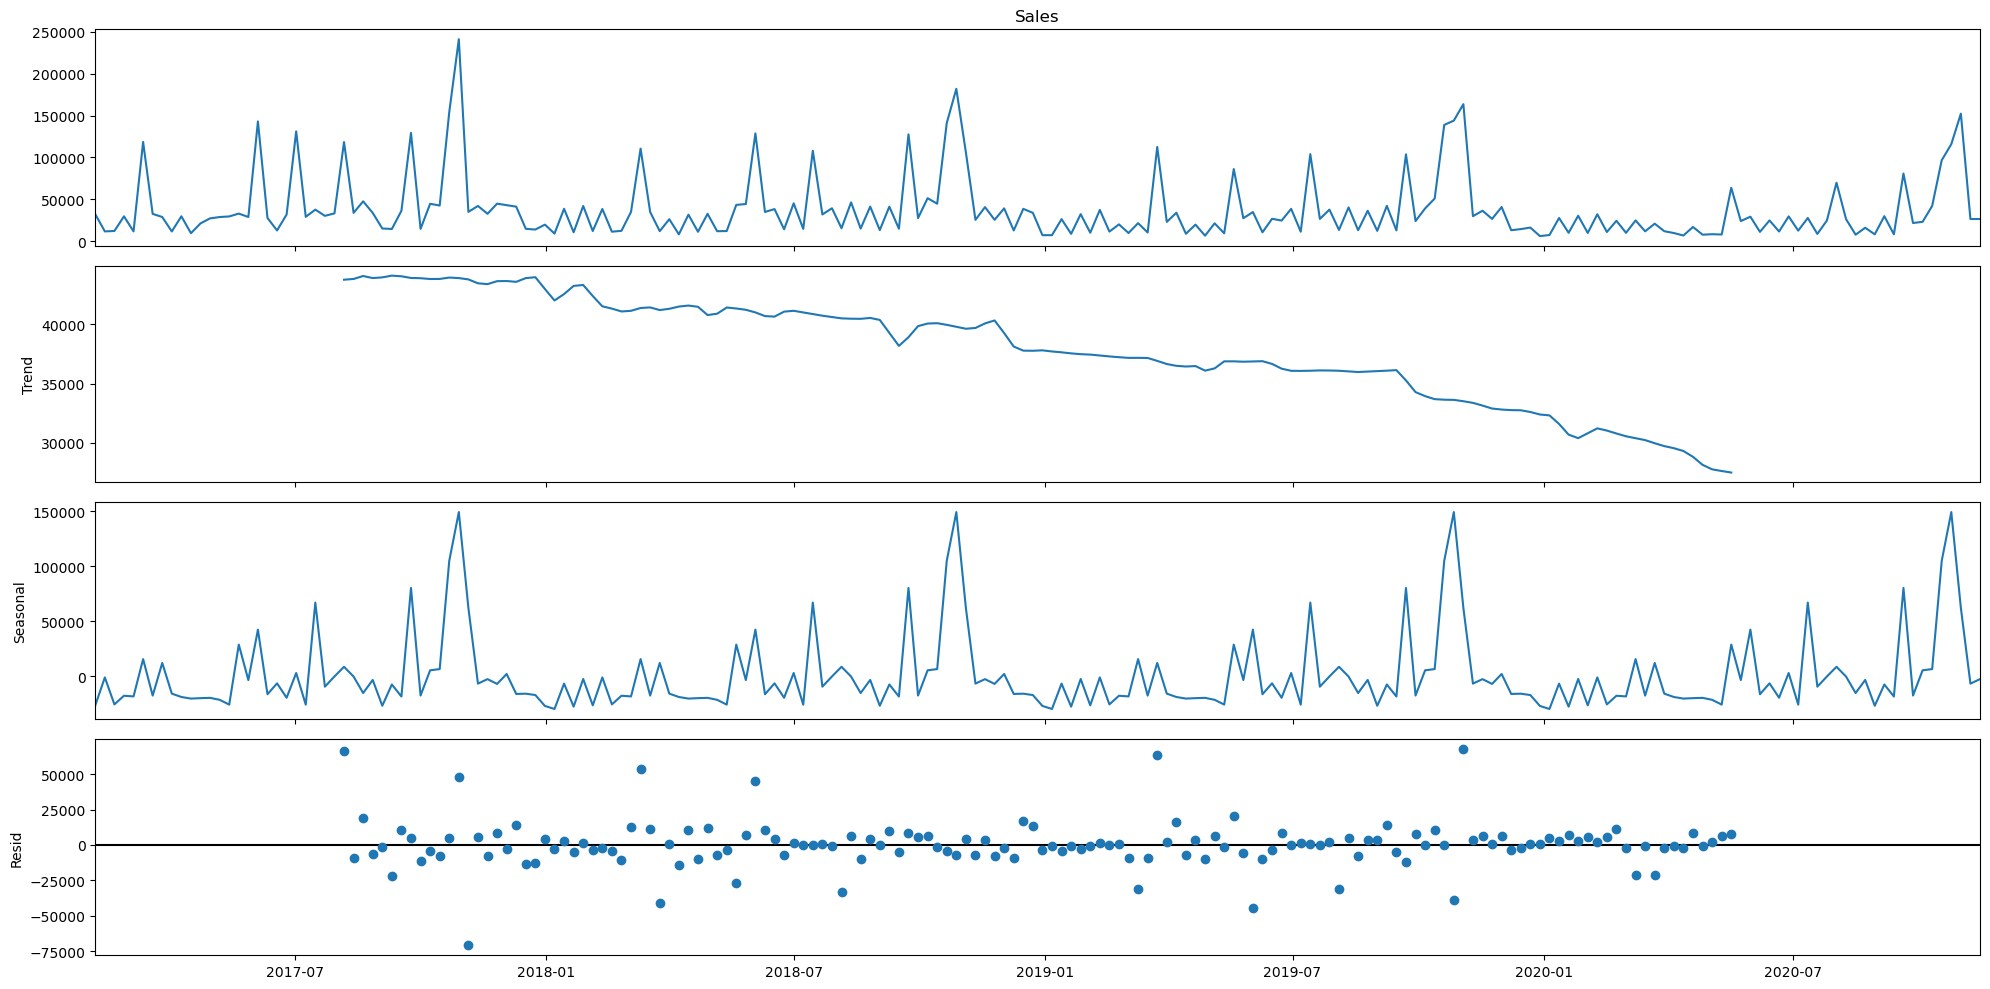

In [70]:
for i in range(1, 7):
    product = "SKU" + str(i)
    product_data = sales_data[sales_data["Product"] == product]
    product_series = product_data.set_index('date').asfreq('W')
    series = pd.Series(product_series['Sales'], index= product_series.index)
    results = seasonal_decompose(series, model='additive')
    print('Trend for ' + product)
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    results.plot()
    plt.show()

The majority of potential outliers are large spikes in sales. These spikes could be caused by factors like promotions, holidays, or other events leading to increased sales. They also display a seasonal trend.
The Z-Score and IQR methods are both detecting these positive sales spikes as outliers.These spikes may not be "errors" in the data but could instead represent meaningful events (e.g., successful promotions, holiday seasons).

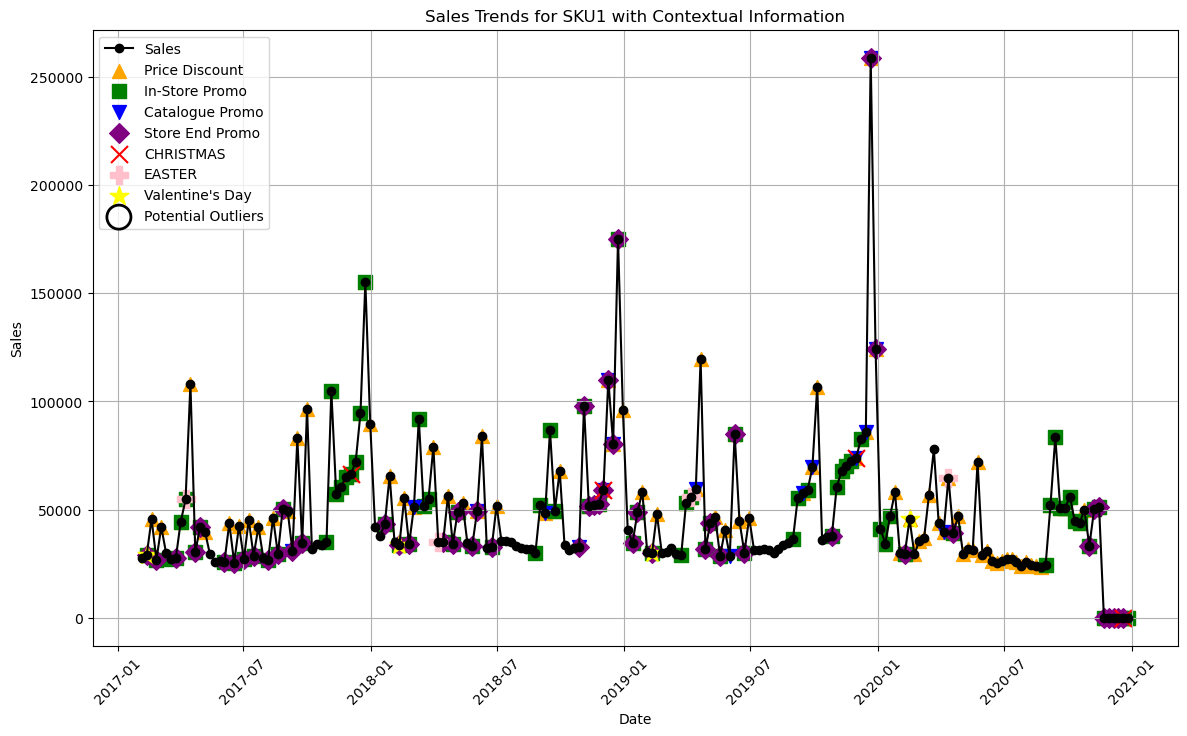

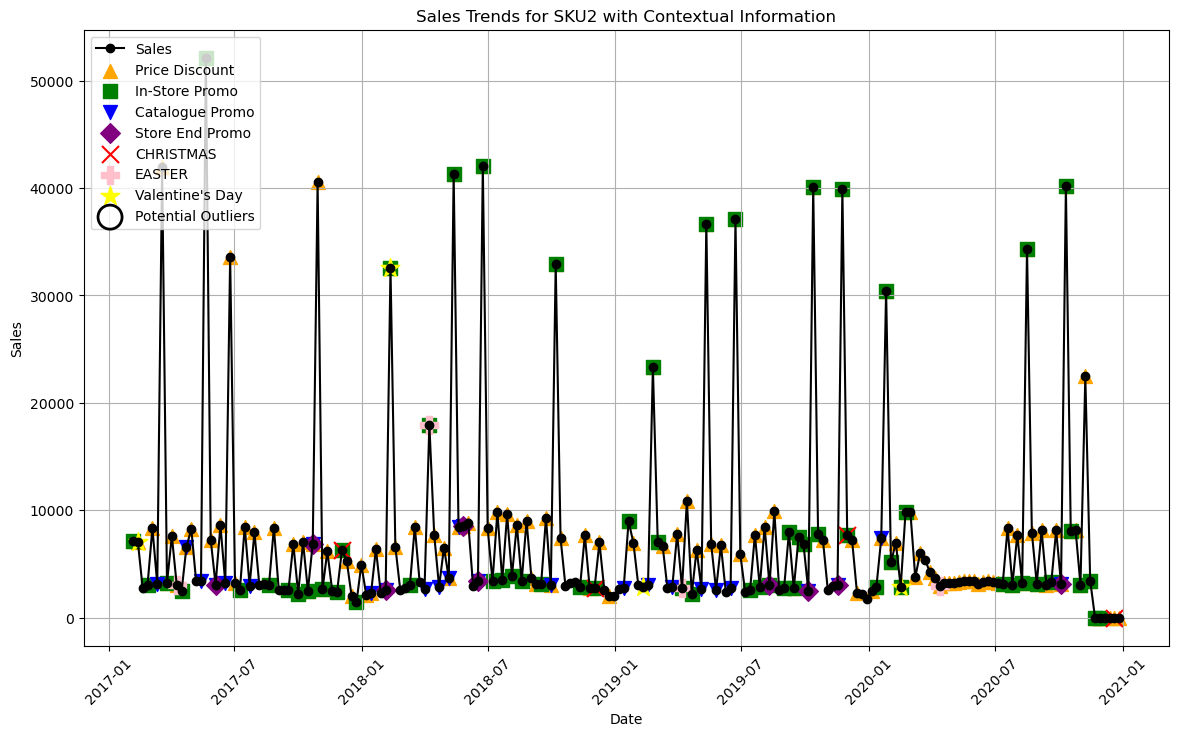

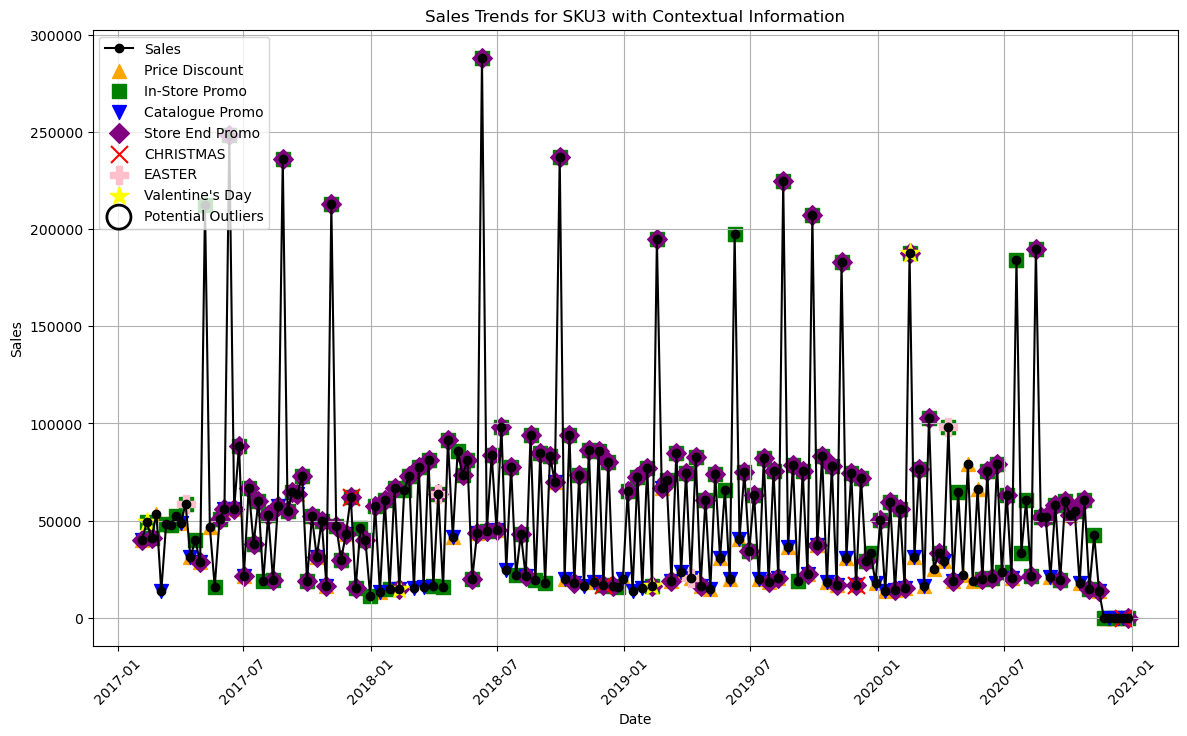

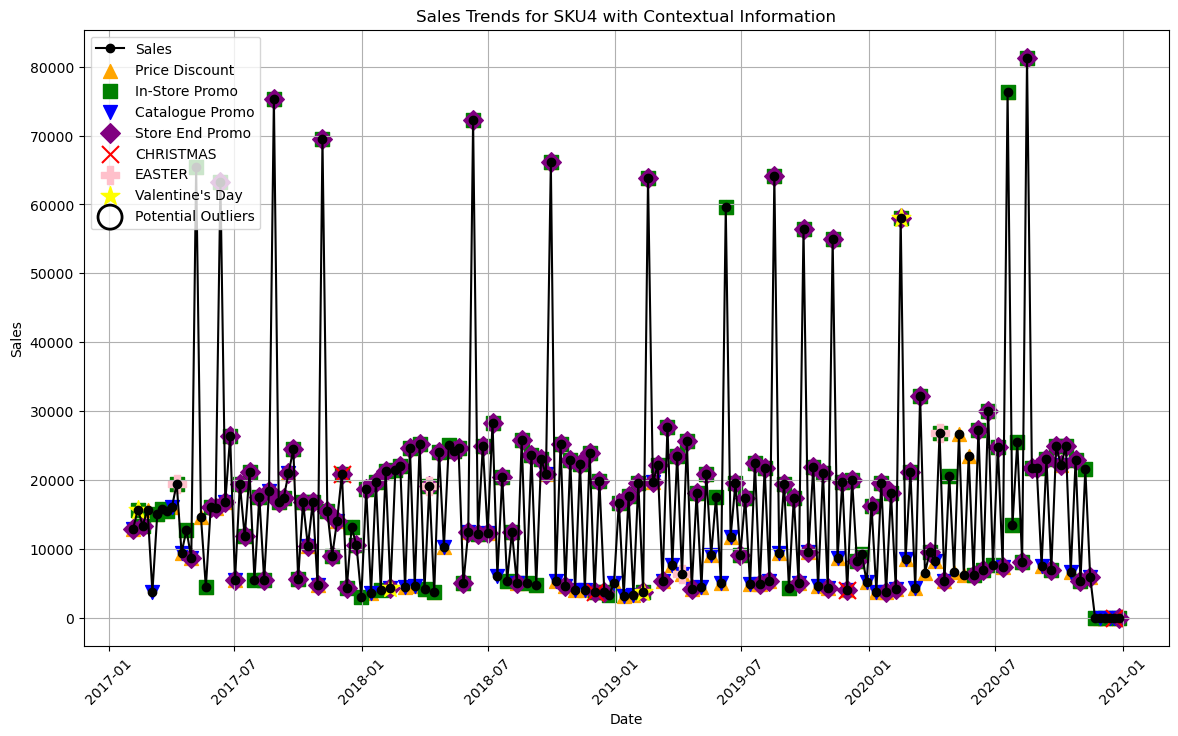

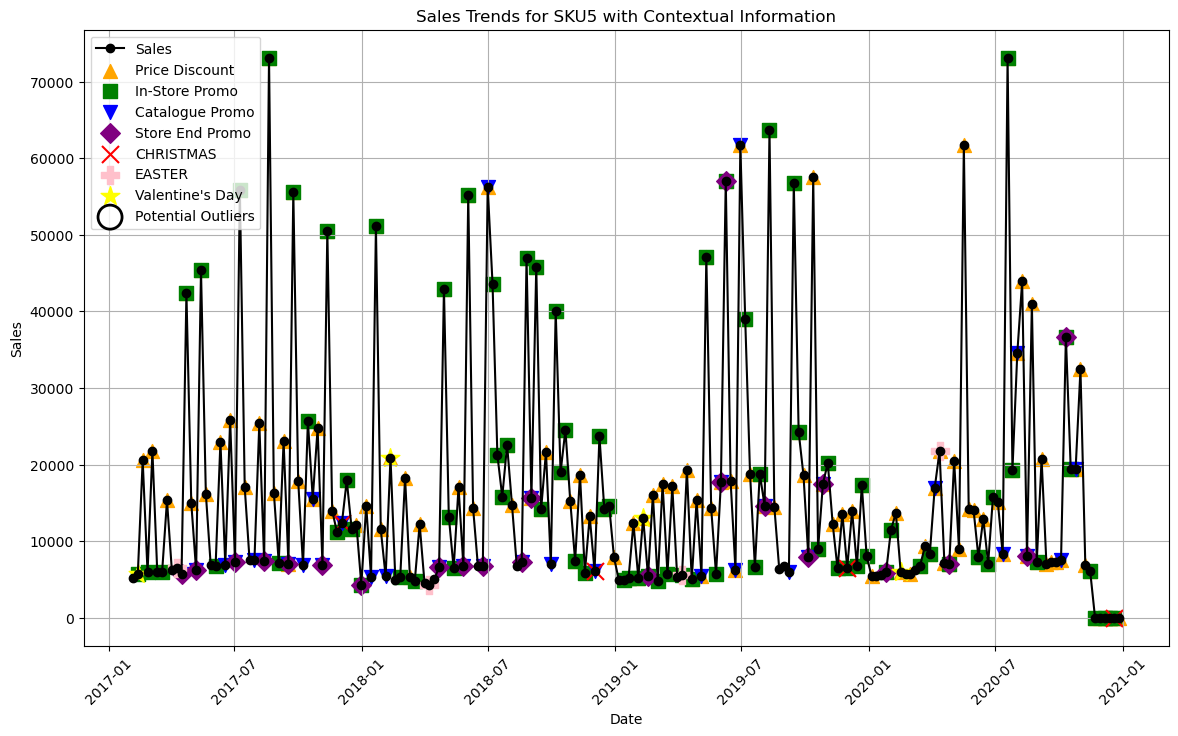

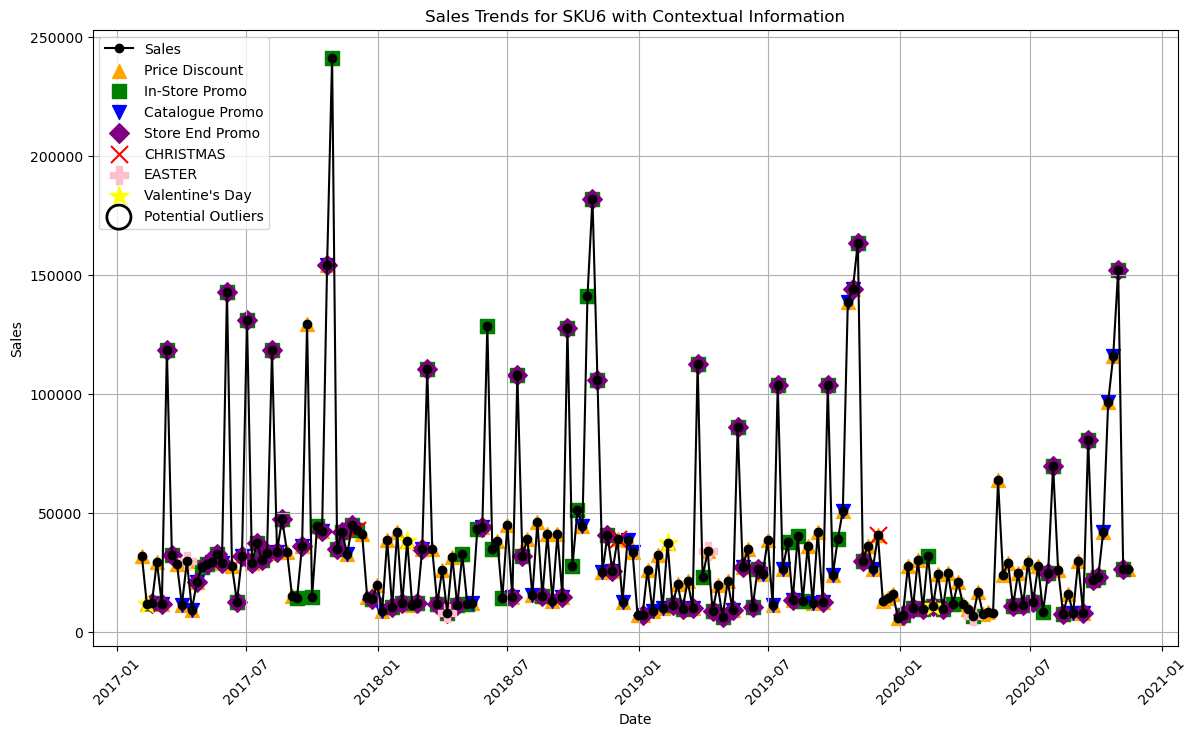

In [16]:
import seaborn as sns
def plot_sales_with_context(df, sku):
    # Filter data for the given SKU
    sku_data = df[df['Product'] == sku].copy()

    # Plot Sales over Time
    plt.figure(figsize=(14, 8))
    plt.plot(sku_data['date'], sku_data['Sales'], label='Sales', marker='o', linestyle='-', color='black')

    # Plot contextual information with different markers and colors
    plt.scatter(sku_data[sku_data['Price Discount (%)'] > 0]['date'],
                sku_data[sku_data['Price Discount (%)'] > 0]['Sales'],
                color='orange', marker='^', s=100, label='Price Discount')

    plt.scatter(sku_data[sku_data['In-Store Promo'] == 1]['date'],
                sku_data[sku_data['In-Store Promo'] == 1]['Sales'],
                color='green', marker='s', s=100, label='In-Store Promo')

    plt.scatter(sku_data[sku_data['Catalogue Promo'] == 1]['date'],
                sku_data[sku_data['Catalogue Promo'] == 1]['Sales'],
                color='blue', marker='v', s=100, label='Catalogue Promo')

    plt.scatter(sku_data[sku_data['Store End Promo'] == 1]['date'],
                sku_data[sku_data['Store End Promo'] == 1]['Sales'],
                color='purple', marker='D', s=100, label='Store End Promo')

    plt.scatter(sku_data[sku_data['CHRISTMAS'] == 1]['date'],
                sku_data[sku_data['CHRISTMAS'] == 1]['Sales'],
                color='red', marker='x', s=150, label='CHRISTMAS')

    plt.scatter(sku_data[sku_data['EASTER'] == 1]['date'],
                sku_data[sku_data['EASTER'] == 1]['Sales'],
                color='pink', marker='P', s=150, label='EASTER')

    plt.scatter(sku_data[sku_data['V_DAY'] == 1]['date'],
                sku_data[sku_data['V_DAY'] == 1]['Sales'],
                color='yellow', marker='*', s=200, label='Valentine\'s Day')

    # Highlight outliers in Sales that don't align with promotions
    outliers = sku_data[sku_data['Sales'].isin(outliers_iqr)] # Example outliers
    plt.scatter(outliers['date'], outliers['Sales'],
                edgecolor='black', facecolor='none', linewidth=2, s=300, marker='o', label='Potential Outliers')
    # Plot settings
    plt.title(f'Sales Trends for {sku} with Contextual Information')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
# Repeat for other SKUs if needed
for sku in sales_data['Product'].unique():
    plot_sales_with_context(sales_data, sku)

The visualization gives us to visibily inspect and cross-reference sales spikes/drops with promotions, holidays, and discounts. Periods where sales spikes or drops without any promotional or holiday context could be due to data entry errors. But we find specific periods where spikes are present because of promotion and holidays which indicates high sales. So they are important data point for us. We can't see any spikes which may not cause by any holidays or promotion result in any potential outliers. So we can't consider those skewness as outliers or data error.

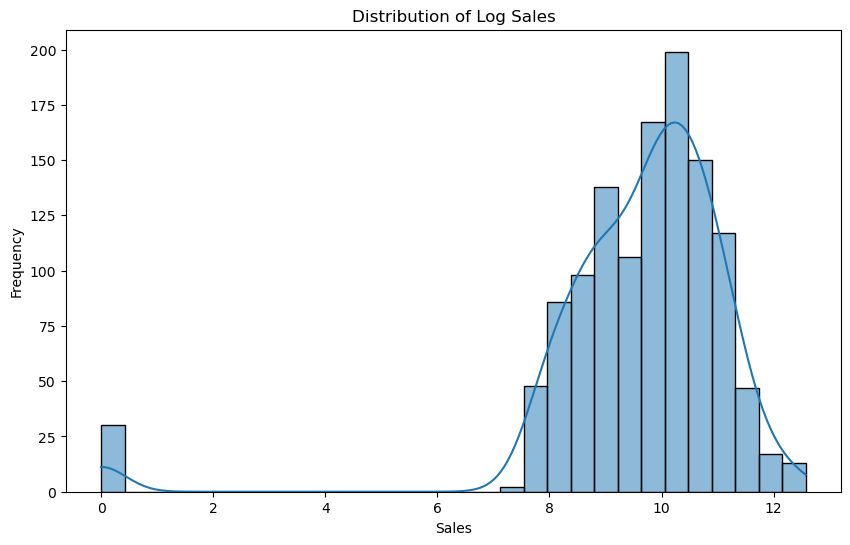

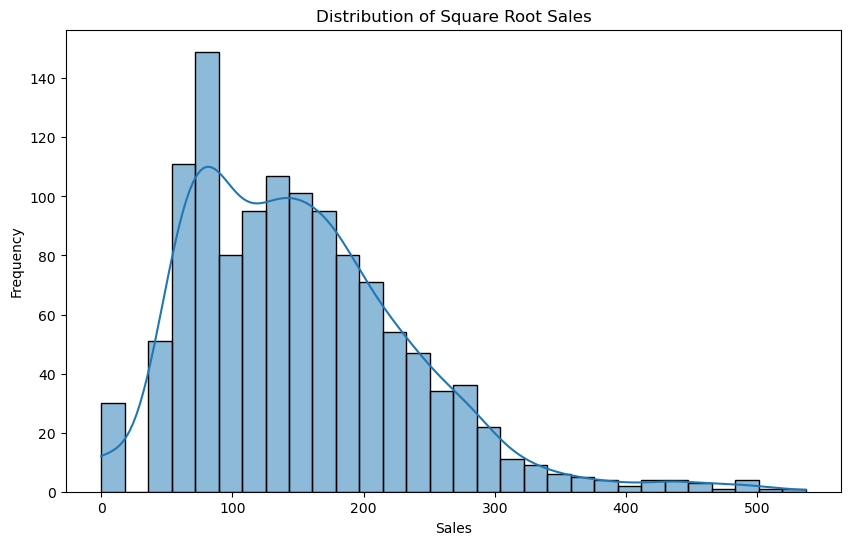

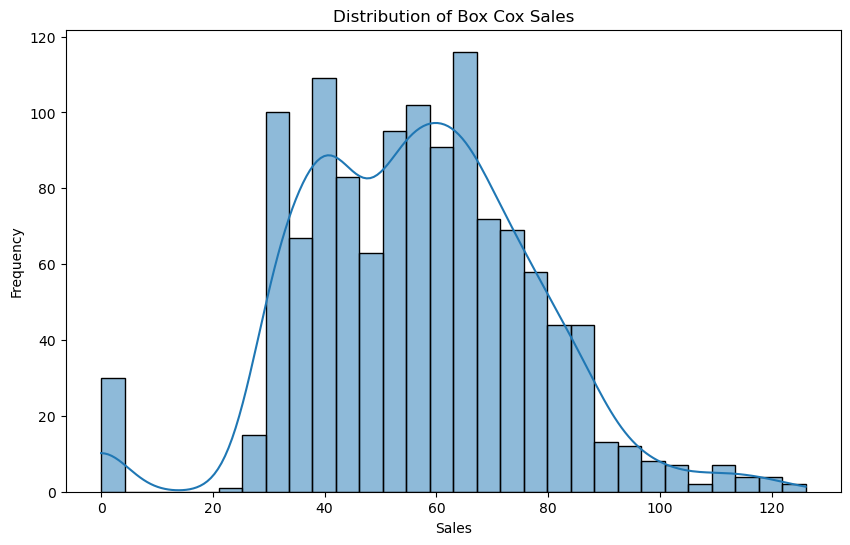

In [90]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Log for Sales
sales_data['Sales_log'] = np.log1p(sales_data['Sales'])

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Sales_log'], kde=True, bins=30)
plt.title('Distribution of Log Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Square root for Sales
sales_data['sales_sqrt'] =np.sqrt(sales_data['Sales'])

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['sales_sqrt'], kde=True, bins=30)
plt.title('Distribution of Square Root Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Box-Cox for Sales (strictly positive data)
sales_data['Sales_boxcox'], _ = boxcox(sales_data['Sales'] + 1)  # Shift to be positive

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Sales_boxcox'], kde=True, bins=30)
plt.title('Distribution of Box Cox Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

We tried transformation technique such as log, square root, and box-cox transformation to reduce the skewness as we can't remove those data points. But even after transformation the skewness seems to persist to some extent. Box-cox seems to help the most.

### Google Mobility

In [59]:
mobility = sales_data[['date', 'Google_Mobility']]
mobility.drop_duplicates(inplace=True)
mobility.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             204 non-null    datetime64[ns]
 1   Google_Mobility  204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3405096298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobility.drop_duplicates(inplace=True)


By keeping only `date` and `Google_Mobility`, we can see that `Google_Mobility` is the same for each product on a given day, so we only need to analyze it once. We will just filter with `SKU1`.

In [74]:
product = "SKU1"
product_data = sales_data[sales_data["Product"] == product]

In [76]:
correlations = product_data[['Google_Mobility', 'Covid_Flag', 'V_DAY', 'EASTER', 'CHRISTMAS',
                           'In-Store Promo', 'Catalogue Promo', 'Store End Promo']].corr()
print(correlations['Google_Mobility'])

Google_Mobility    1.000000
Covid_Flag        -0.755472
V_DAY              0.078580
EASTER            -0.108024
CHRISTMAS         -0.004172
In-Store Promo     0.070383
Catalogue Promo    0.043660
Store End Promo    0.103851
Name: Google_Mobility, dtype: float64


In [78]:
from scipy import stats

# Calculate Z-scores
z_scores = stats.zscore(product_data[['Google_Mobility']])
product_data['z_scores'] = z_scores

# Filter outliers
outliers = product_data[abs(product_data['z_scores']) > 3]
print(outliers[['Google_Mobility', 'Covid_Flag', 'V_DAY', 'EASTER', 'CHRISTMAS',
                'In-Store Promo', 'Catalogue Promo', 'Store End Promo']])

     Google_Mobility  Covid_Flag  V_DAY  EASTER  CHRISTMAS  In-Store Promo  \
164           -26.63           1      0       0          0               0   
165           -28.49           1      0       0          0               0   
166           -27.30           1      0       1          0               0   
167           -24.28           1      0       0          0               1   
168           -22.58           1      0       0          0               0   
184           -20.35           1      0       0          0               0   

     Catalogue Promo  Store End Promo  
164                0                0  
165                1                0  
166                0                0  
167                0                1  
168                0                0  
184                0                0  


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3539511592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data['z_scores'] = z_scores


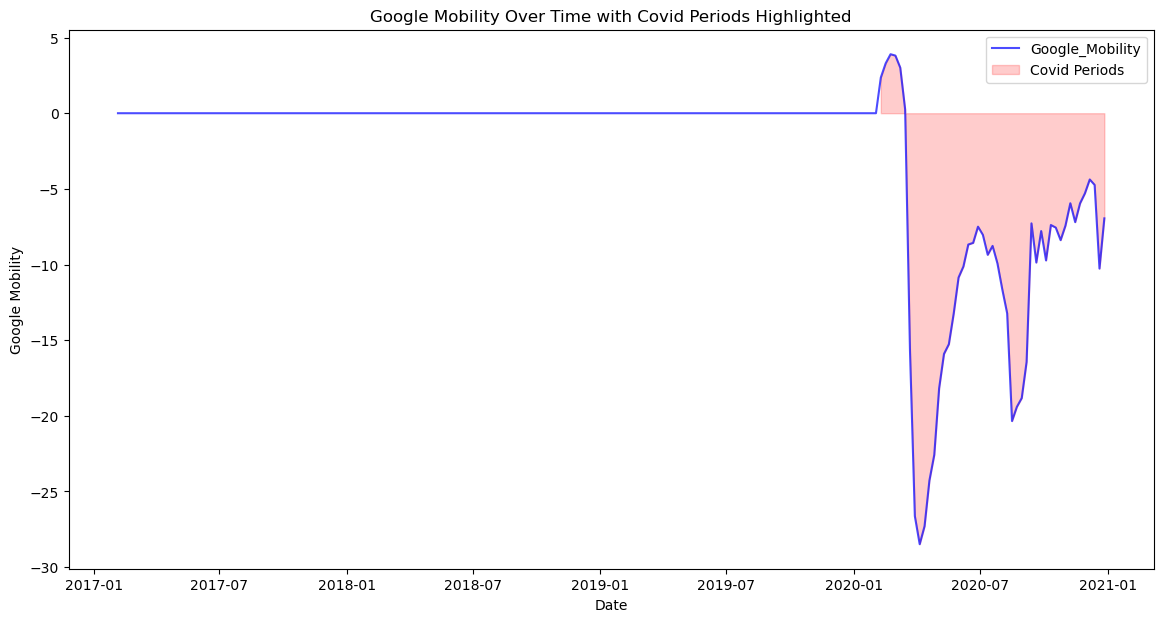

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the time series of Google Mobility with Covid_Flag
plt.figure(figsize=(14, 7))
plt.plot(product_data['date'], product_data['Google_Mobility'], label='Google_Mobility', color='blue', alpha=0.7)

# Highlight periods with Covid_Flag
plt.fill_between(product_data['date'],
                 product_data['Google_Mobility'],
                 where=product_data['Covid_Flag'] == 1,
                 color='red', alpha=0.2, label='Covid Periods')

plt.title('Google Mobility Over Time with Covid Periods Highlighted')
plt.xlabel('Date')
plt.ylabel('Google Mobility')
plt.legend()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18312\3294821456.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Covid_Flag', y='Google_Mobility', data=product_data, palette='Set2')


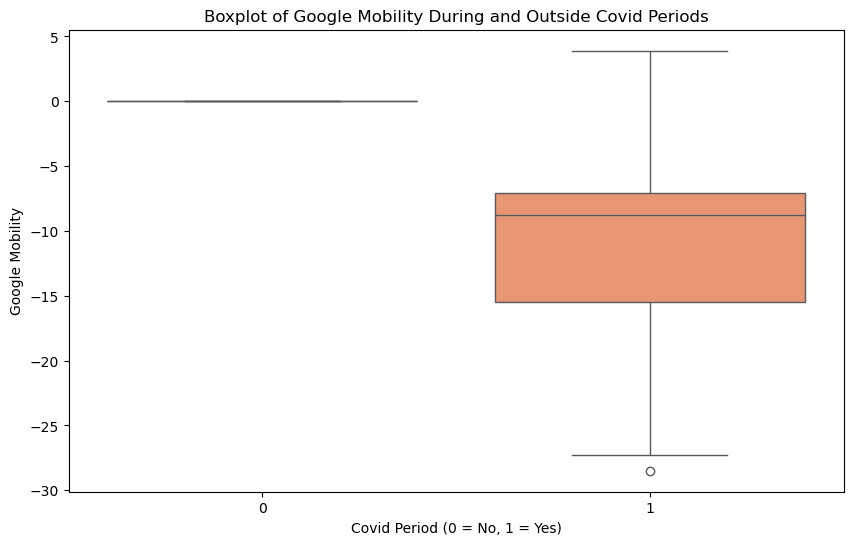

In [82]:
# Creating a boxplot to compare Google Mobility during and outside Covid periods
plt.figure(figsize=(10, 6))
sns.boxplot(x='Covid_Flag', y='Google_Mobility', data=product_data, palette='Set2')
plt.title('Boxplot of Google Mobility During and Outside Covid Periods')
plt.xlabel('Covid Period (0 = No, 1 = Yes)')
plt.ylabel('Google Mobility')
plt.show()

* To determine why "Google_Mobility" is left-skewed and whether it’s influenced by factors like COVID, holidays, or promotions, we need to investigate how these factors correlate with Google Mobility and whether they contribute to the skewness.
* The visualization sggests that the drop of Google_Mobility are primarily driven by the COVID-19 pandemic period. A strong negative correlation with Google_Mobility. This indicates that Google_Mobility tends to be significantly lower. During these times, mobility was heavily restricted, which explains the drop and the skewness.
* Other factors like Valentine's Day, Easter, Christmas, and different types of promotions have only weak correlations with Google_Mobility, implying that they do not contribute significantly to the left skewness.
* So we can't cosider those extremely low data points as outliers. We will have to keep those for our further predictions and trends.

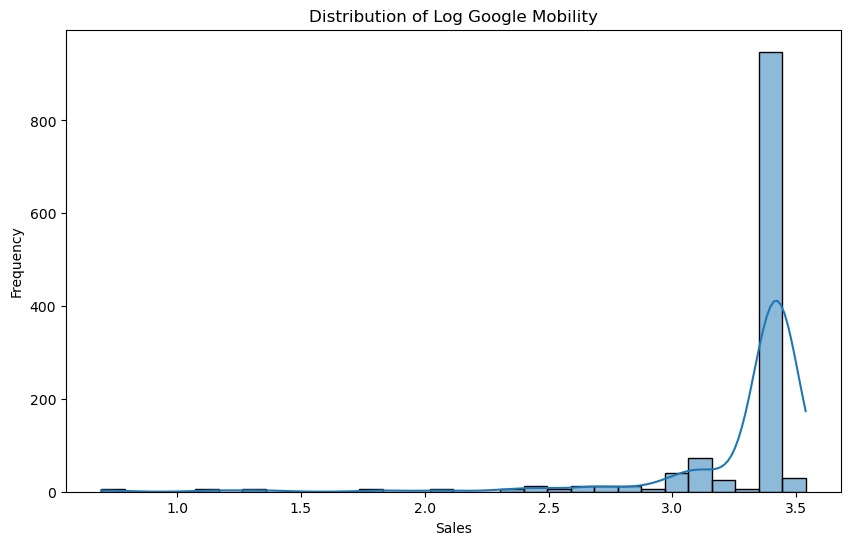

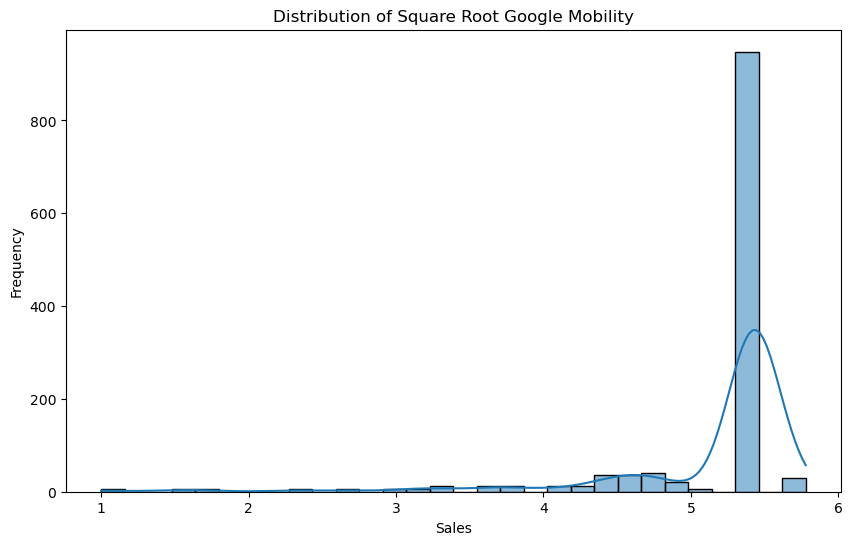

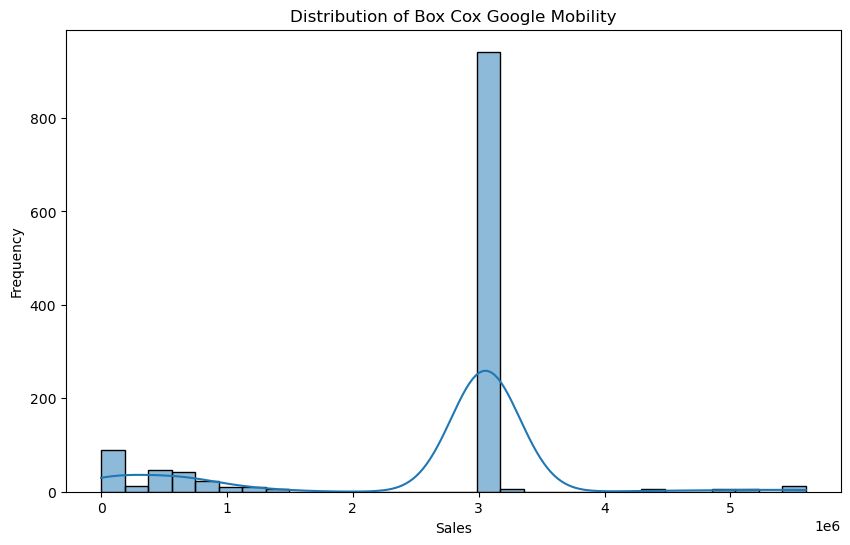

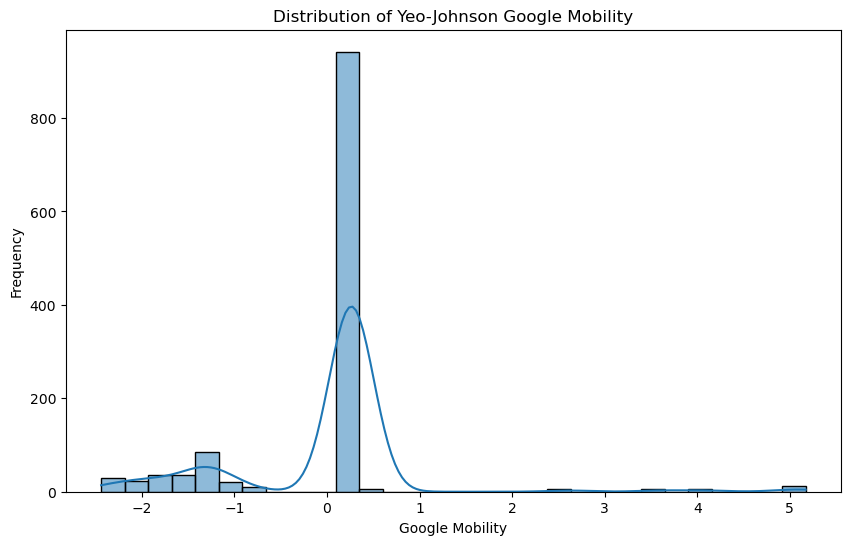

In [93]:
# Log for Google Mobility
sales_data['Google_Mobility_log'] = np.log1p(sales_data['Google_Mobility'] + abs(sales_data['Google_Mobility'].min()) + 1)  # Shifting values to be positive

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility_log'], kde=True, bins=30)
plt.title('Distribution of Log Google Mobility')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Square root for Google Mobility
sales_data['Google_Mobility__sqrt'] =np.sqrt(sales_data['Google_Mobility'] + abs(sales_data['Google_Mobility'].min()) + 1)

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility__sqrt'], kde=True, bins=30)
plt.title('Distribution of Square Root Google Mobility')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Box-Cox for Google Mobility (strictly positive data)
sales_data['Google_Mobility_boxcox'], _ = boxcox(sales_data['Google_Mobility'] + abs(sales_data['Google_Mobility'].min()) + 1)  # Shift to be positive

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility_boxcox'], kde=True, bins=30)
plt.title('Distribution of Box Cox Google Mobility')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Yeo-Johnson for Google Mobility (handles both positive and negative data)
pt = PowerTransformer(method='yeo-johnson')
sales_data['Google_Mobility_yeojohnson'] = pt.fit_transform(sales_data[['Google_Mobility']])

plt.figure(figsize=(10, 6))
sns.histplot(sales_data['Google_Mobility_yeojohnson'], kde=True, bins=30)
plt.title('Distribution of Yeo-Johnson Google Mobility')
plt.xlabel('Google Mobility')
plt.ylabel('Frequency')
plt.show()

We tried transformation technique such as log, square root, box-cox and Yeo-Johnson transformation to reduce the skewness as we can't remove those data points. But even after transformation the skewness seems to persist to some extent.